In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

In [ ]:
exp_dirs = ["expo_500_shots", "expo_1k_shots", "expo_5k_shots", "expo_10k_shots", "expo_500_shots_pareto","expo_1000_shots_pareto","expo_5000_shots_pareto"] # expo_20k_shots

In [3]:
# colors = {
#     "vanilla": sns.color_palette()[0],
#     "cc": sns.color_palette()[1],
#     "sw": sns.color_palette()[2],
#     "cc_sw": sns.color_palette()[3],
    
#     "cc_all": sns.color_palette()[4],
#     "sw_without": sns.color_palette()[2],
#     "sw_after": sns.color_palette()[3],
    
#     "1k": sns.color_palette()[0],
#     "5k": sns.color_palette()[1],
#     "10k": sns.color_palette()[2],
# }

# legend = {
#     "vanilla": "Naive",
#     "cc": "Only Circuit Cutting",
#     "sw": "Only Shot-Wise",
#     "cc_sw": "Cut&Shoot",
    
#     "cc_all": "Circuit Cutting",
#     "sw_without": "Shot-Wise (Without Circuit Cutting)",
#     "sw_after": "Shot-Wise (After Circuit Cutting)",
# }

dir = "./experiments_results/"

paths = [dir + exp_dir + "/" for exp_dir in exp_dirs]
paths

['./experiments_results/expo_500_shots/',
 './experiments_results/expo_1k_shots/',
 './experiments_results/expo_5k_shots/',
 './experiments_results/expo_10k_shots/']

In [4]:
plots_dir = "./plots/"

if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [5]:
def parse_data(data, file, path, _dir):
    
    dispatch = []
    for _, backends_data in data["stats"]["dispatch"].items():
        for _, circuits_data in backends_data.items():
            for _,shots in circuits_data:
                dispatch.append(shots)
                
    results = data["results"]
    if type(results) == dict:
        _results = None
        for _,b_d in results.items():
            for _, c_d in b_d.items():
                for _, r in c_d.items():
                    _results = r
        results = _results
        
    error = data["error"]
    if type(error) == dict:
        _error = None
        for _,b_d in error.items():
            for _, c_d in b_d.items():
                for _, r in c_d.items():
                    _error = r
        error = _error
        
    error = abs(error) if error != None else None
    
    sew_time = data["times"]["time_sew"] if "time_sew" in data["times"] else None
    if sew_time is not None and type(sew_time) == dict:
        _sew_time = []
        for _,b_d in sew_time.items():
            for _, r in b_d.items():
                    _sew_time.append(r)
        sew_time = max(_sew_time)
    

    cc_overhead = 0
    cc_overhead += data["times"]["time_cutting"] if "time_cutting" in data["times"] else 0
    cc_overhead += sew_time if sew_time is not None else 0
    
    sw_overhead = 0
    sw_overhead += data["times"]["time_dispatch"] if "time_dispatch" in data["times"] else 0
    sw_overhead += data["times"]["time_merge"] if "time_merge" in data["times"] else 0
    
    return {
            "id": file,
            "exp": path,
            "operation": _dir,
            "shots": data["params"]["shots"],
            "backends": data["params"]["backends"],
            "backends_len": len(data["params"]["backends"]),
            "cut_strategy": data["params"]["cut_strategy"] if "cut_strategy" in data["params"] else None,
            "shots_allocation": data["params"]["shots_allocation"].replace("cutshot.src.policies.","") if "shots_allocation" in data["params"] else None,
            "shot_wise_policy": data["params"]["shot_wise_policy"] if "shot_wise_policy" in data["params"] else None,
            "circuit_name": data["params"]["circuit_name"],
            "qubits": data["params"]["n_qubits"],
            "results": results,
            "error": error,
            "time_cutting": data["times"]["time_cutting"] if "time_cutting" in data["times"] else None,
            "time_allocation": data["times"]["time_allocation"] if "time_allocation" in data["times"] else None,
            "time_dispatch": data["times"]["time_dispatch"],
            "time_execution": data["times"]["time_execution"],
            "time_synchronization": data["times"]["time_synchronization"],
            "time_counts": data["times"]["time_counts"],
            "time_merge": data["times"]["time_merge"] if "time_merge" in data["times"] else None,
            "time_expected_values": data["times"]["time_expected_values"] if "time_expected_values" in data["times"] else None,
            "time_sew": sew_time if sew_time is not None else 0,
            "time_total": data["times"]["time_total"],
            "depth": data["stats"]["circuit_stats"]["depth"],
            "num_gates": data["stats"]["circuit_stats"]["num_gates"],
            "2q_depth": data["stats"]["circuit_stats"]["2q_depth"],
            "num_1q_gates": data["stats"]["circuit_stats"]["num_1q_gates"],
            "num_2q_gates": data["stats"]["circuit_stats"]["num_2q_gates"],
            "num_measurements": data["stats"]["circuit_stats"]["num_measurements"],
            "num_fragments": data["stats"]["cut_info"]["num_fragments"] if "cut_info" in data["stats"] else None,
            "num_variations": data["stats"]["cut_info"]["num_variations"] if "cut_info" in data["stats"] else None,
            "min_fragments_qubits": min(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "max_fragments_qubits": max(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "avg_fragments_qubits": np.mean(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "median_fragments_qubits": np.median(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "std_fragments_qubits": np.std(data["stats"]["cut_info"]["fragments_qubits"]) if "cut_info" in data["stats"] else None,
            "min_variations": min(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "max_variations": max(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "avg_variations": np.mean(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "median_variations": np.median(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "std_variations": np.std(data["stats"]["cut_info"]["variations"]) if "cut_info" in data["stats"] else None,
            "min_shots": min(dispatch),
            "max_shots": max(dispatch),
            "avg_shots": np.mean(dispatch),
            "median_shots": np.median(dispatch),
            "std_shots": np.std(dispatch),
            "min_shots_norm": min(dispatch) / np.mean(dispatch),
            "max_shots_norm": max(dispatch) / np.mean(dispatch),
            "avg_shots_norm": np.mean(dispatch) / data["params"]["shots"],
            "median_shots_norm": np.median(dispatch) / np.mean(dispatch),
            "std_shots_norm": np.std(dispatch) / np.mean(dispatch),
            "error_norm": error / np.mean(dispatch) if error != None else None,
            "cc_overhead": cc_overhead,
            "sw_overhead": sw_overhead,
        }

In [6]:
exp_dfs = []

for path in paths:
    _df = []
    for _dir in ["vanilla", "cc", "sw", "cc_sw"]:
        dir_path = path + _dir + "/"
        for file in os.listdir(dir_path):
            with open(dir_path + file) as f:
                data = json.load(f)
                if data["params"]["operation"] != _dir:
                    raise Exception(f"Operation is not the same as the directory name: {data['operation']} != {_dir} in {path}/{file}")
                _df.append(parse_data(data, file, path, _dir))
    exp_dfs.append(pd.DataFrame(_df))
    
exp_dfs

[                                                     id  \
 0             14281_q10_vanilla_n4_r2_k2_p1_s18_b0.json   
 1              8929_q10_vanilla_n4_r2_k2_p1_s27_b3.json   
 2             16071_q10_vanilla_n4_r2_k2_p1_s15_b5.json   
 3               1786_q14_vanilla_n4_r3_k1_p1_s2_b0.json   
 4              5358_q14_vanilla_n4_r3_k1_p1_s11_b2.json   
 ...                                                 ...   
 24993  10099_q10_cc_sw_n4_r2_k2_p1_s27_b2_b4_b5_b6.json   
 24994  15325_q10_cc_sw_n4_r2_k2_p1_s18_b1_b2_b4_b5.json   
 24995  16995_q10_cc_sw_n4_r2_k2_p1_s15_b0_b2_b4_b6.json   
 24996  25937_q5_cc_sw_n2_r2_k1_p1_s149_b0_b2_b5_b7.json   
 24997  13491_q10_cc_sw_n4_r2_k2_p1_s22_b0_b4_b5_b6.json   
 
                                          exp operation  shots  \
 0      ./experiments_results/expo_500_shots/   vanilla    500   
 1      ./experiments_results/expo_500_shots/   vanilla    500   
 2      ./experiments_results/expo_500_shots/   vanilla    500   
 3      ./expe

In [7]:
df = pd.concat(exp_dfs)
df = df.reset_index(drop=True)
df

,id,exp,operation,shots,backends,backends_len,cut_strategy,shots_allocation,shot_wise_policy,circuit_name,...,median_shots,std_shots,min_shots_norm,max_shots_norm,avg_shots_norm,median_shots_norm,std_shots_norm,error_norm,cc_overhead,sw_overhead
0,14281_q10_vanilla_n4_r2_k2_p1_s18_b0.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r2_k2_p1_s18,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,4.024882e-05,0.000000,0.000007
1,8929_q10_vanilla_n4_r2_k2_p1_s27_b3.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_sherbrooke]]",1,None,None,None,n4_r2_k2_p1_s27,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,5.601906e-05,0.000000,0.000007
2,16071_q10_vanilla_n4_r2_k2_p1_s15_b5.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_kawasaki]]",1,None,None,None,n4_r2_k2_p1_s15,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,9.600983e-05,0.000000,0.000008
3,1786_q14_vanilla_n4_r3_k1_p1_s2_b0.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r3_k1_p1_s2,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,7.999687e-05,0.000000,0.000008
4,5358_q14_vanilla_n4_r3_k1_p1_s11_b2.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_osaka]]",1,None,None,None,n4_r3_k1_p1_s11,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,6.437450e-22,0.000000,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100947,10099_q10_cc_sw_n4_r2_k2_p1_s27_b2_b4_b5_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_osaka], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,qubit_exp,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s27,...,312.0,144.375325,0.537815,1.462985,0.031238,0.9988,0.462186,5.728579e-07,1.128491,0.001779
100948,15325_q10_cc_sw_n4_r2_k2_p1_s18_b1_b2_b4_b5.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_kyoto], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,multiplier,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s18,...,2500.0,0.000000,1.000000,1.000000,0.250000,1.0000,0.000000,2.334031e-07,1.186730,0.002335
100949,16995_q10_cc_sw_n4_r2_k2_p1_s15_b0_b2_b4_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,divider,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s15,...,312.5,0.500000,0.998400,1.001600,0.031250,1.0000,0.001600,1.563119e-07,0.992003,0.001938
100950,25937_q5_cc_sw_n2_r2_k1_p1_s149_b0_b2_b5_b7.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,2qgates_exp,cutshot.src.policies.sw_fair_policies,n2_r2_k1_p1_s149,...,312.5,0.500000,0.998400,1.001600,0.031250,1.0000,0.001600,3.093299e-05,0.499370,0.000562


In [8]:
print("STO RIMUOVENDO TUTTI GLI ESPERIMENTI CON 2Q GATES EXPONENTIAL E PROPORTIONAL")
df = df[(df["shots_allocation"] != "2qgates_proportional") & (df["shots_allocation"] != "2qgates_exponential")]
df

STO RIMUOVENDO TUTTI GLI ESPERIMENTI CON 2Q GATES EXPONENTIAL E PROPORTIONAL


,id,exp,operation,shots,backends,backends_len,cut_strategy,shots_allocation,shot_wise_policy,circuit_name,...,median_shots,std_shots,min_shots_norm,max_shots_norm,avg_shots_norm,median_shots_norm,std_shots_norm,error_norm,cc_overhead,sw_overhead
0,14281_q10_vanilla_n4_r2_k2_p1_s18_b0.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r2_k2_p1_s18,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,4.024882e-05,0.000000,0.000007
1,8929_q10_vanilla_n4_r2_k2_p1_s27_b3.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_sherbrooke]]",1,None,None,None,n4_r2_k2_p1_s27,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,5.601906e-05,0.000000,0.000007
2,16071_q10_vanilla_n4_r2_k2_p1_s15_b5.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_kawasaki]]",1,None,None,None,n4_r2_k2_p1_s15,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,9.600983e-05,0.000000,0.000008
3,1786_q14_vanilla_n4_r3_k1_p1_s2_b0.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_brisbane]]",1,None,None,None,n4_r3_k1_p1_s2,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,7.999687e-05,0.000000,0.000008
4,5358_q14_vanilla_n4_r3_k1_p1_s11_b2.json,./experiments_results/expo_500_shots/,vanilla,500,"[[ibm_aer, aer.fake_osaka]]",1,None,None,None,n4_r3_k1_p1_s11,...,500.0,0.000000,1.000000,1.000000,1.000000,1.0000,0.000000,6.437450e-22,0.000000,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100947,10099_q10_cc_sw_n4_r2_k2_p1_s27_b2_b4_b5_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_osaka], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,qubit_exp,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s27,...,312.0,144.375325,0.537815,1.462985,0.031238,0.9988,0.462186,5.728579e-07,1.128491,0.001779
100948,15325_q10_cc_sw_n4_r2_k2_p1_s18_b1_b2_b4_b5.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_kyoto], [ibm_aer, aer.fake...",4,cutshot.src.pennylane_tool,multiplier,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s18,...,2500.0,0.000000,1.000000,1.000000,0.250000,1.0000,0.000000,2.334031e-07,1.186730,0.002335
100949,16995_q10_cc_sw_n4_r2_k2_p1_s15_b0_b2_b4_b6.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,divider,cutshot.src.policies.sw_fair_policies,n4_r2_k2_p1_s15,...,312.5,0.500000,0.998400,1.001600,0.031250,1.0000,0.001600,1.563119e-07,0.992003,0.001938
100950,25937_q5_cc_sw_n2_r2_k1_p1_s149_b0_b2_b5_b7.json,./experiments_results/expo_10k_shots/,cc_sw,10000,"[[ibm_aer, aer.fake_brisbane], [ibm_aer, aer.f...",4,cutshot.src.pennylane_tool,2qgates_exp,cutshot.src.policies.sw_fair_policies,n2_r2_k1_p1_s149,...,312.5,0.500000,0.998400,1.001600,0.031250,1.0000,0.001600,3.093299e-05,0.499370,0.000562


In [9]:
# Define the required columns
columns_to_keep = [
    "circuit_name", "qubits", "depth", "num_gates", "2q_depth", "num_1q_gates", "num_2q_gates", "num_measurements",
    "num_fragments", "num_variations", "min_fragments_qubits", "max_fragments_qubits",
    "avg_fragments_qubits", "median_fragments_qubits", "std_fragments_qubits", "min_variations",
    "max_variations", "avg_variations", "median_variations", "std_variations"
]

# Filter the DataFrame with selected columns
filtered_df = df[columns_to_keep]

filtered_df["qubits"] = filtered_df["qubits"].astype(int)

aggregated_df = filtered_df.groupby("circuit_name", as_index=True).mean()

aggregated_df

/var/folders/wq/p5kk0_8x1g92_4gnbhvd2bgc0000gn/T/ipykernel_16190/451139019.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["qubits"] = filtered_df["qubits"].astype(int)


,qubits,depth,num_gates,2q_depth,num_1q_gates,num_2q_gates,num_measurements,num_fragments,num_variations,min_fragments_qubits,max_fragments_qubits,avg_fragments_qubits,median_fragments_qubits,std_fragments_qubits,min_variations,max_variations,avg_variations,median_variations,std_variations
circuit_name,,,,,,,,,,,,,,,,,,,
n2_r2_k1_p1_s113,5.0,12.0,27.0,6.0,19.0,8.0,5.0,2.0,8.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0
n2_r2_k1_p1_s127,5.0,12.0,27.0,6.0,19.0,8.0,5.0,2.0,8.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0
n2_r2_k1_p1_s136,5.0,12.0,27.0,6.0,19.0,8.0,5.0,2.0,8.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0
n2_r2_k1_p1_s149,5.0,12.0,27.0,6.0,19.0,8.0,5.0,2.0,8.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0
n2_r2_k1_p1_s25,5.0,12.0,27.0,6.0,19.0,8.0,5.0,2.0,8.0,3.0,3.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0
n4_r2_k2_p1_s15,10.0,18.0,60.0,10.0,40.0,20.0,10.0,2.0,8.0,5.0,6.0,5.5,5.5,0.5,4.0,4.0,4.0,4.0,0.0
n4_r2_k2_p1_s18,10.0,21.0,72.0,12.0,44.0,28.0,10.0,2.0,8.0,5.0,6.0,5.5,5.5,0.5,4.0,4.0,4.0,4.0,0.0
n4_r2_k2_p1_s22,10.0,18.0,69.0,10.0,43.0,26.0,10.0,2.0,8.0,5.0,6.0,5.5,5.5,0.5,4.0,4.0,4.0,4.0,0.0
n4_r2_k2_p1_s24,10.0,15.0,57.0,8.0,39.0,18.0,10.0,2.0,2.0,4.0,6.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0


In [10]:
_filtered_df = filtered_df.copy()
# remove the circuit_name column
_filtered_df = _filtered_df.drop(columns=["circuit_name"])
qubits_df = _filtered_df.groupby("qubits", as_index=True).mean()
qubits_df.T

qubits,5,10,14
depth,12.0,18.613677,22.770590
num_gates,27.0,64.704258,98.379327
2q_depth,6.0,10.409118,13.180393
num_1q_gates,19.0,41.568086,60.793109
num_2q_gates,8.0,23.136172,37.586218
num_measurements,5.0,10.000000,14.000000
num_fragments,2.0,2.000000,2.000000
num_variations,8.0,6.767024,2.000000
min_fragments_qubits,3.0,4.794504,4.819607
max_fragments_qubits,3.0,6.000000,9.180393


In [11]:
styles = ["linear"]
x_axes = ["backends_len", "qubits", "shots_allocation", "shots"]
y_axes = ["error", "avg_shots", "std_shots", "time_total", "time_execution", "time_synchronization", "cc_overhead", "sw_overhead"]
hue_axes = ["operation", "shots"]

shots_allocation_order = ["multiplier", "divider", "qubit_proportional", "qubit_exp"]

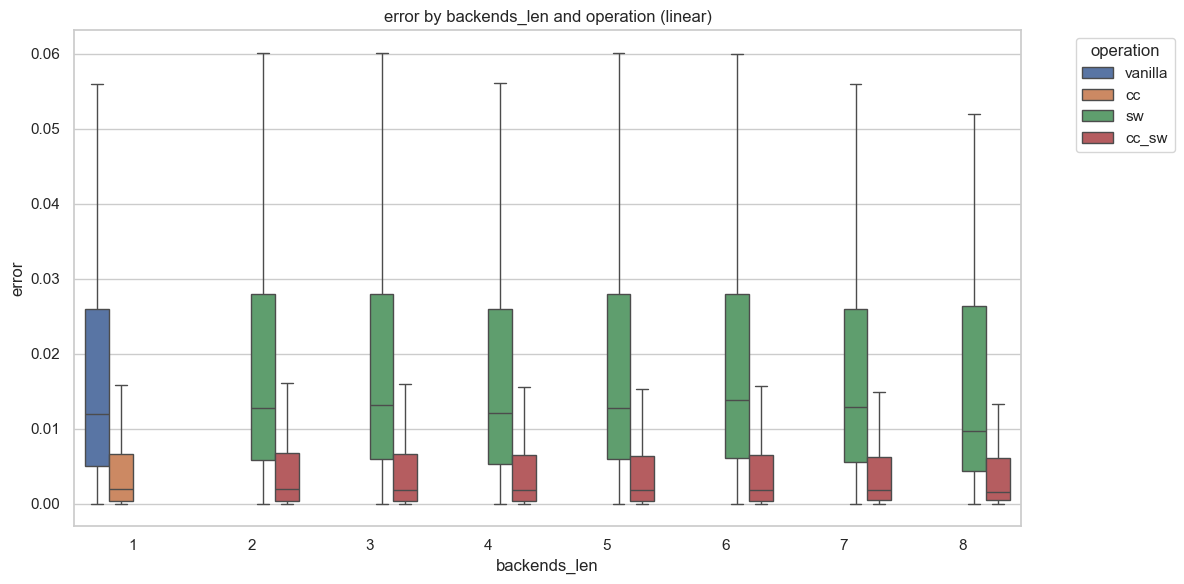

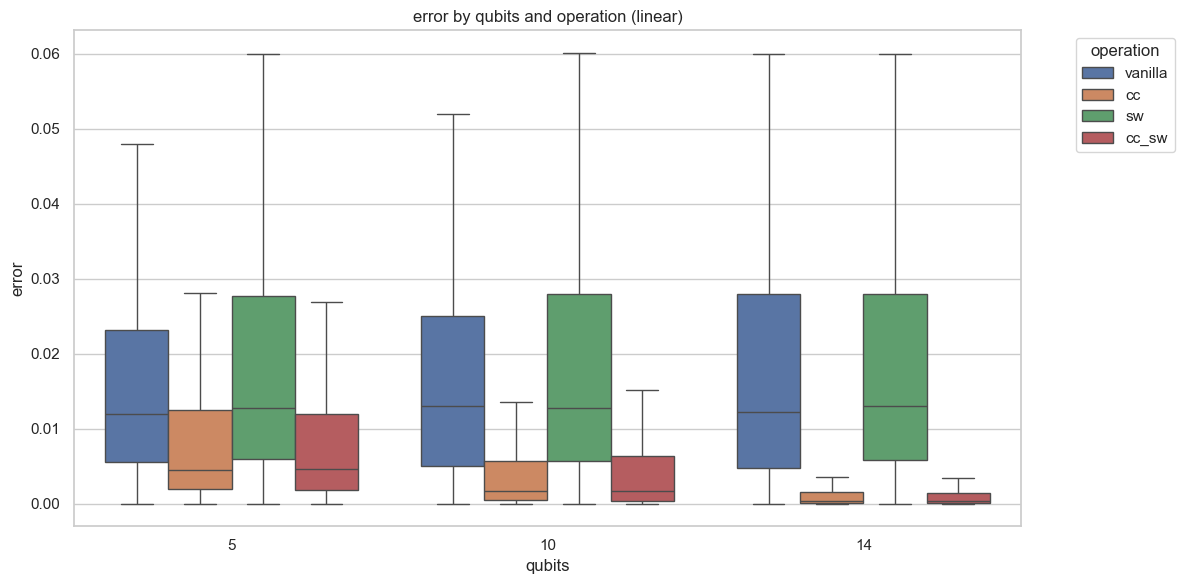

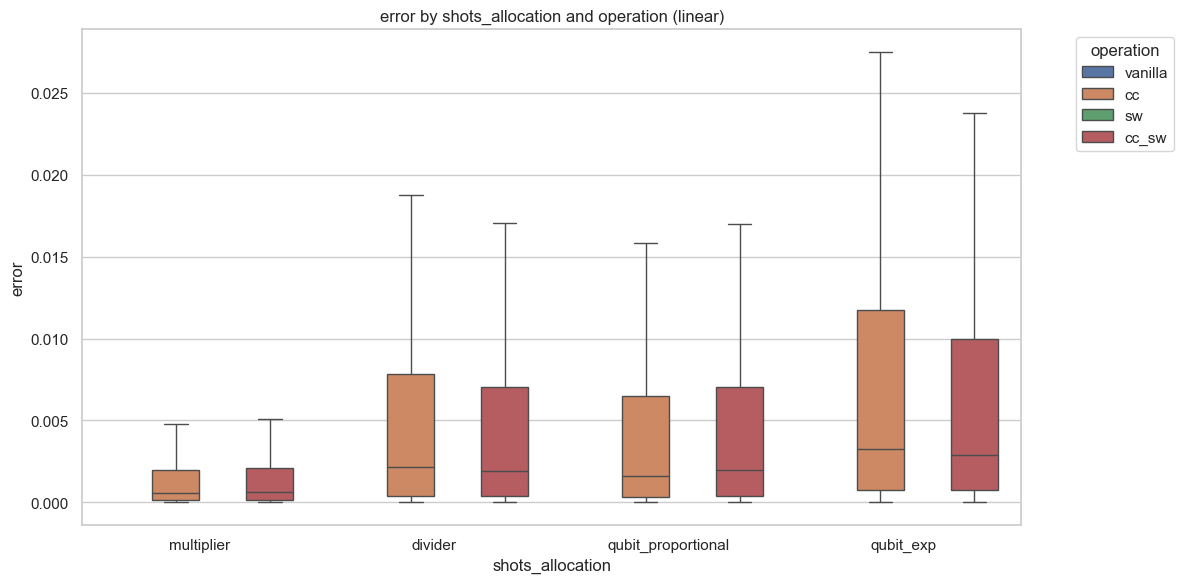

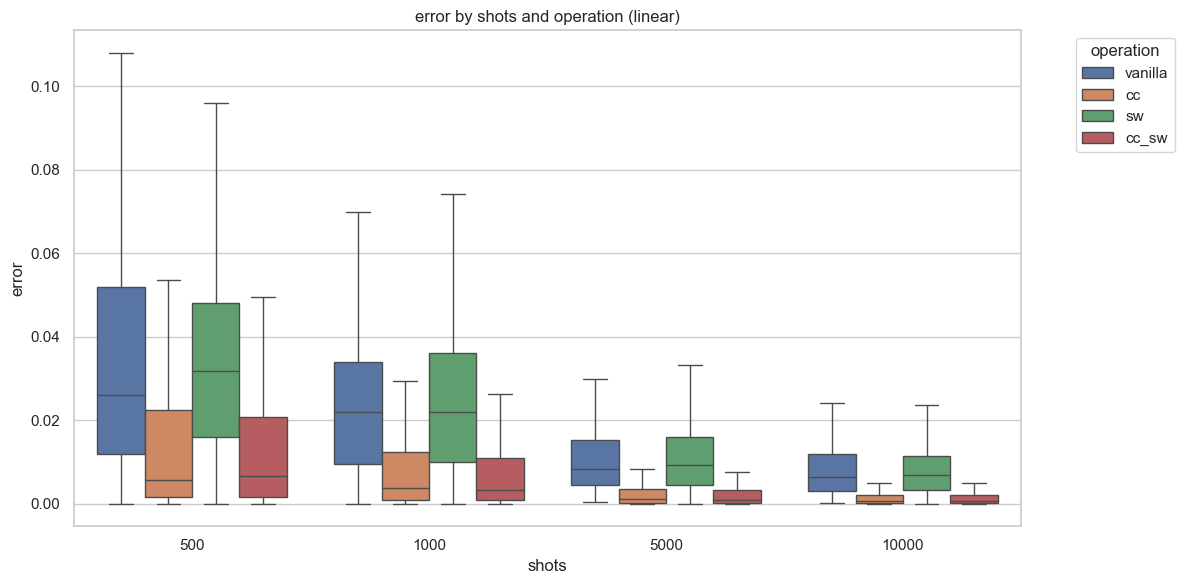

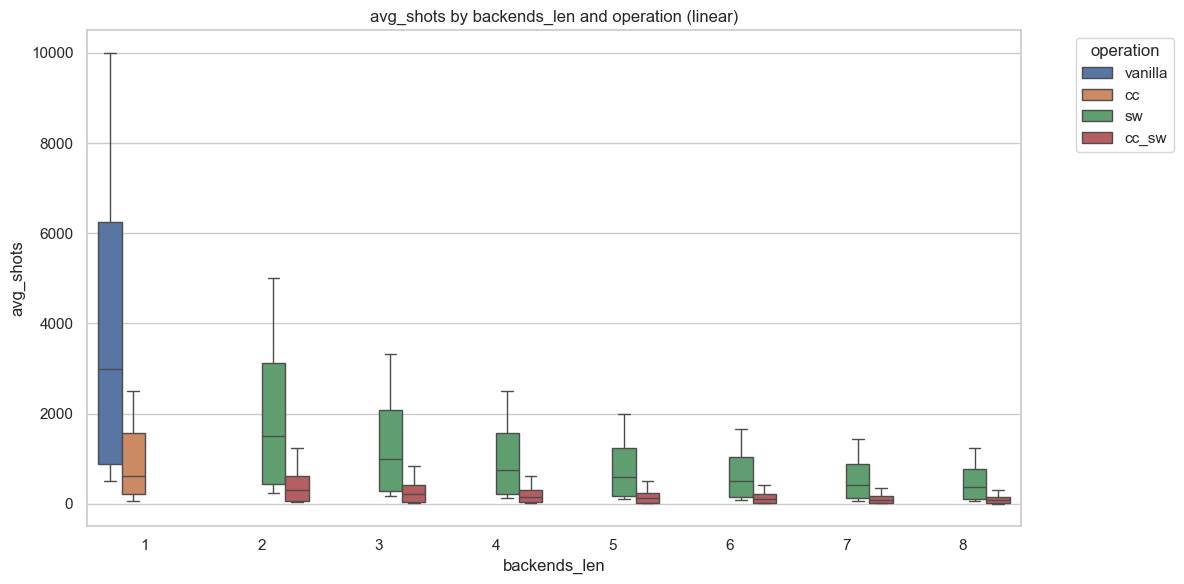

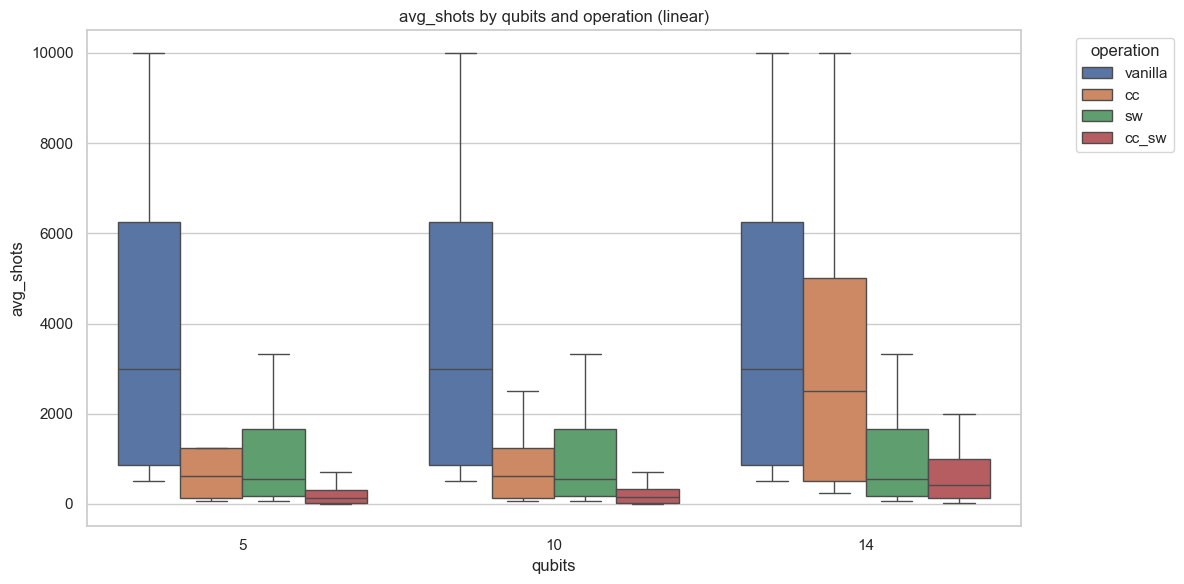

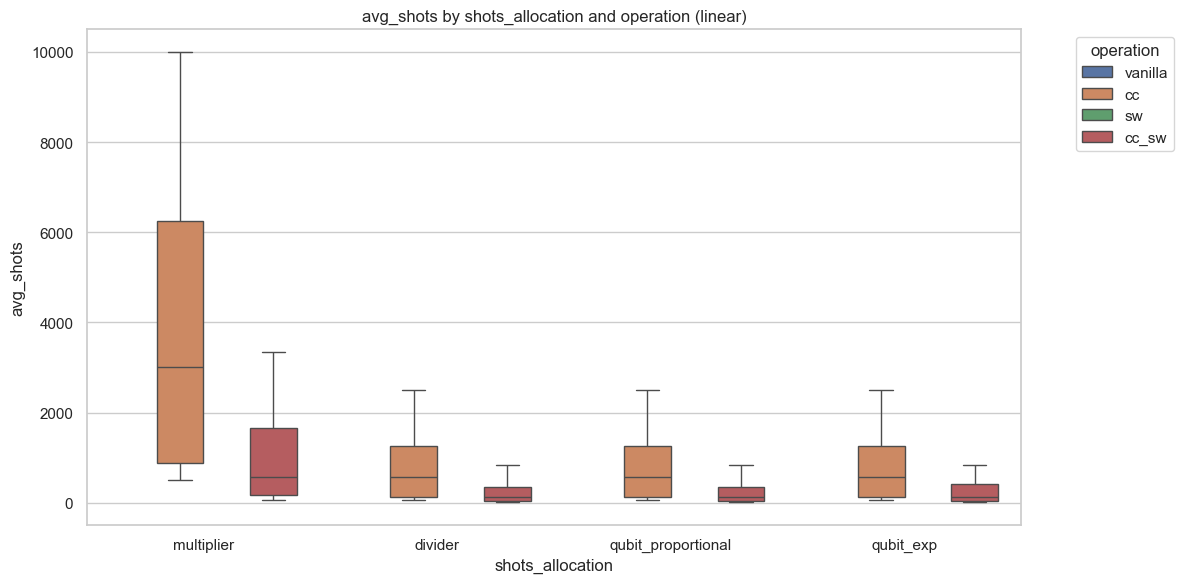

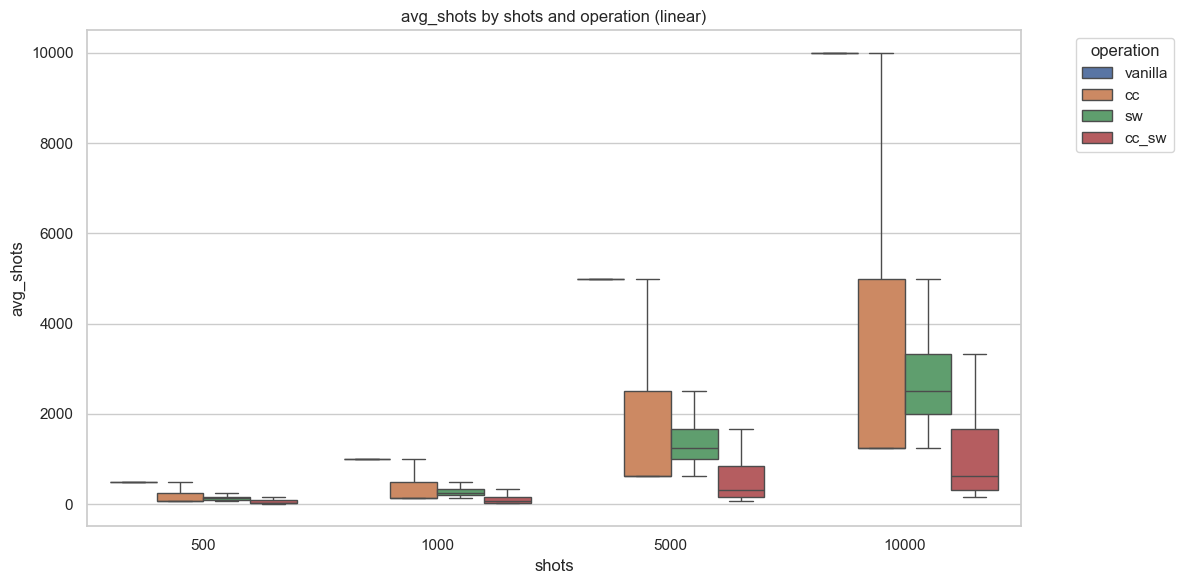

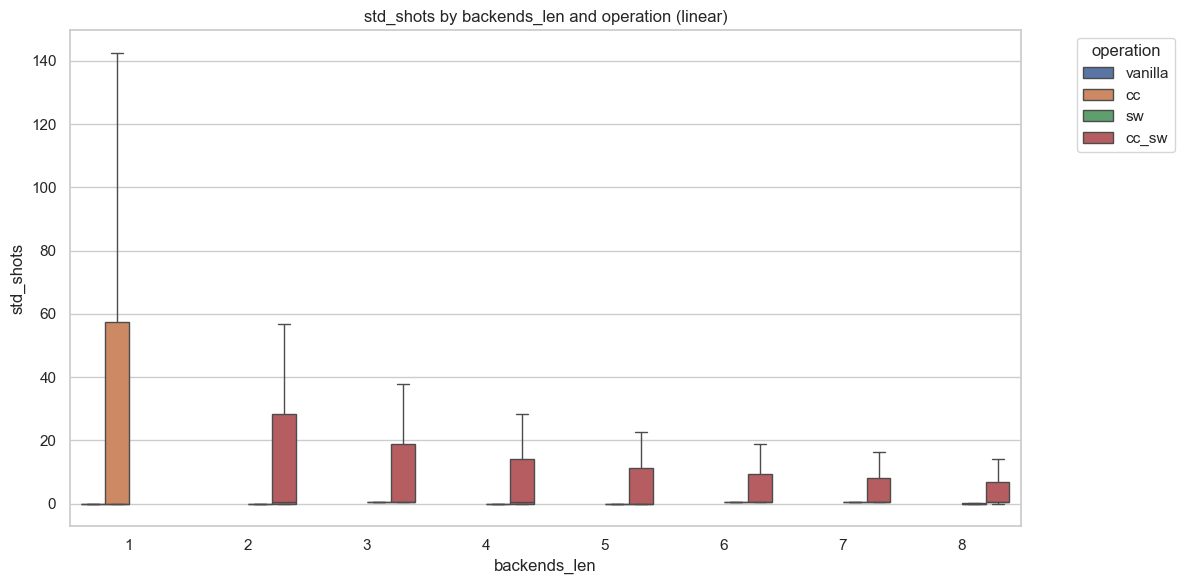

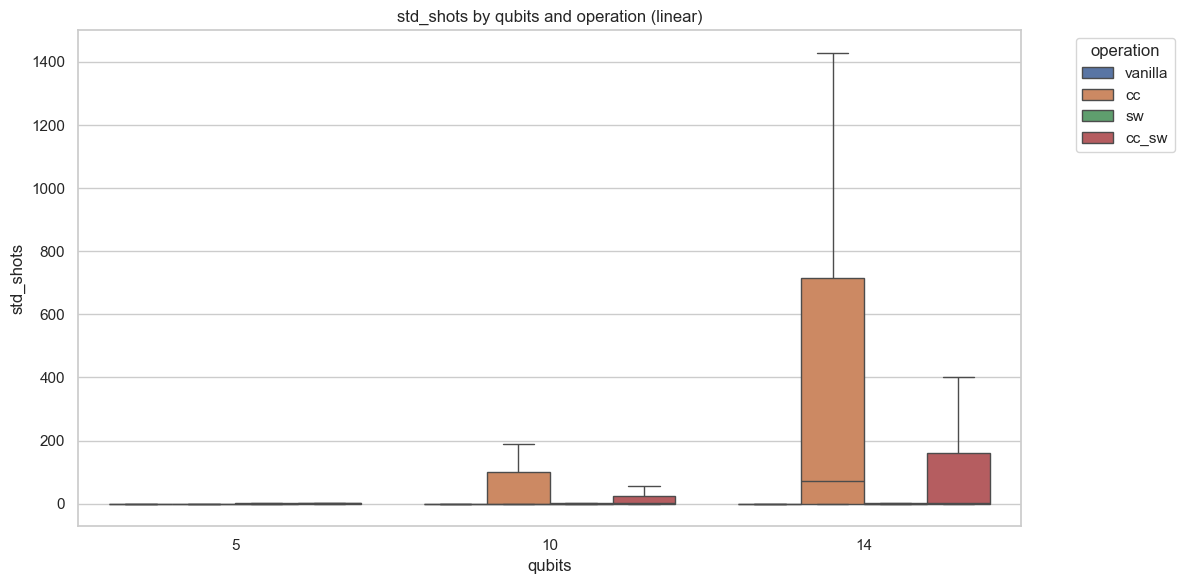

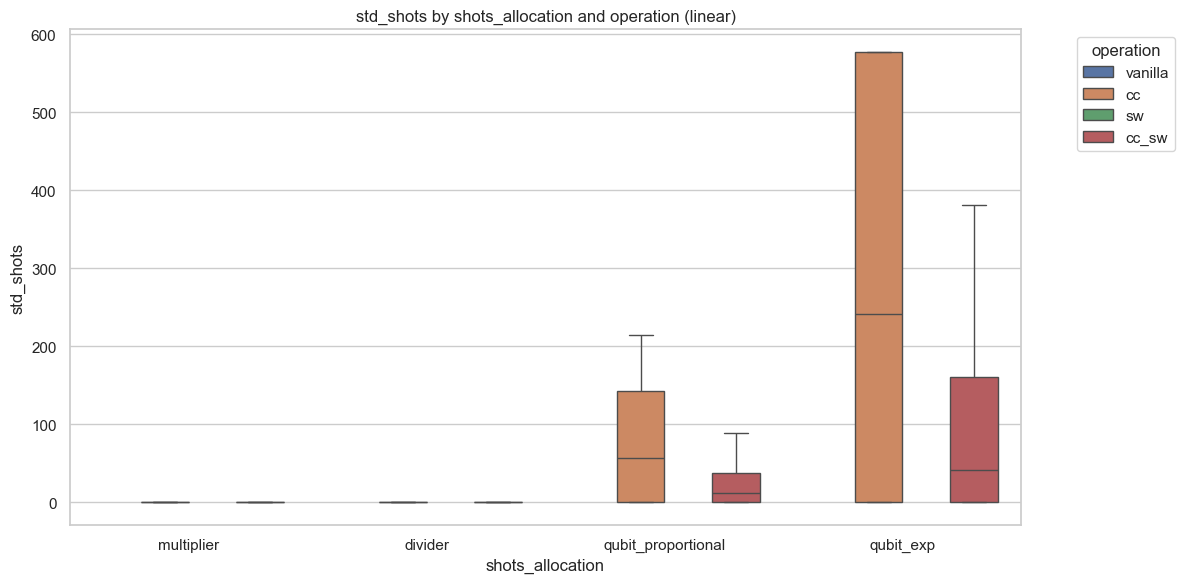

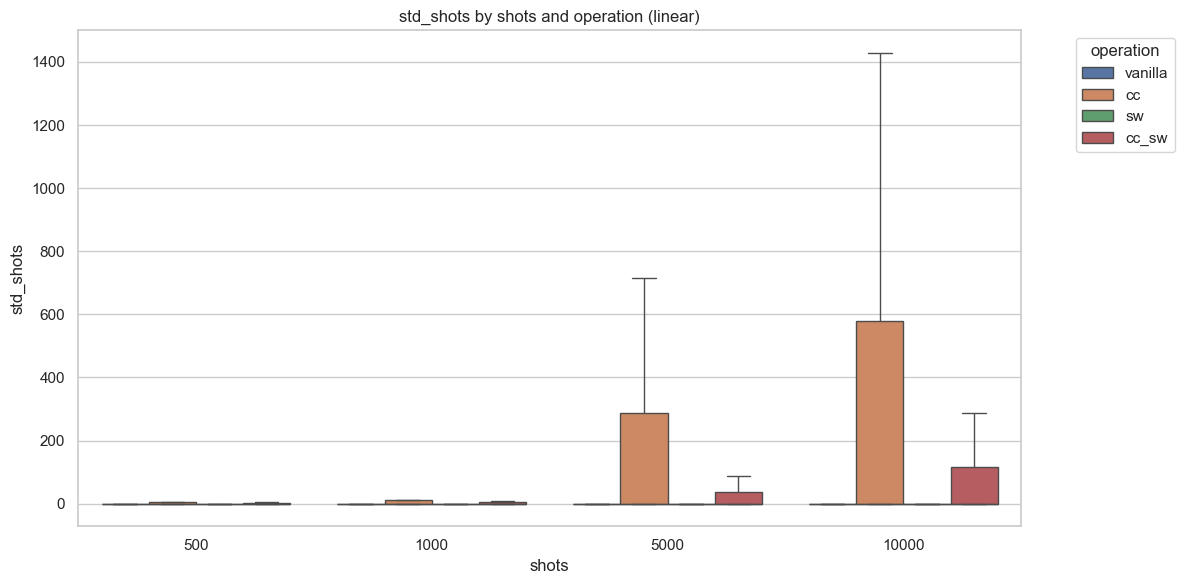

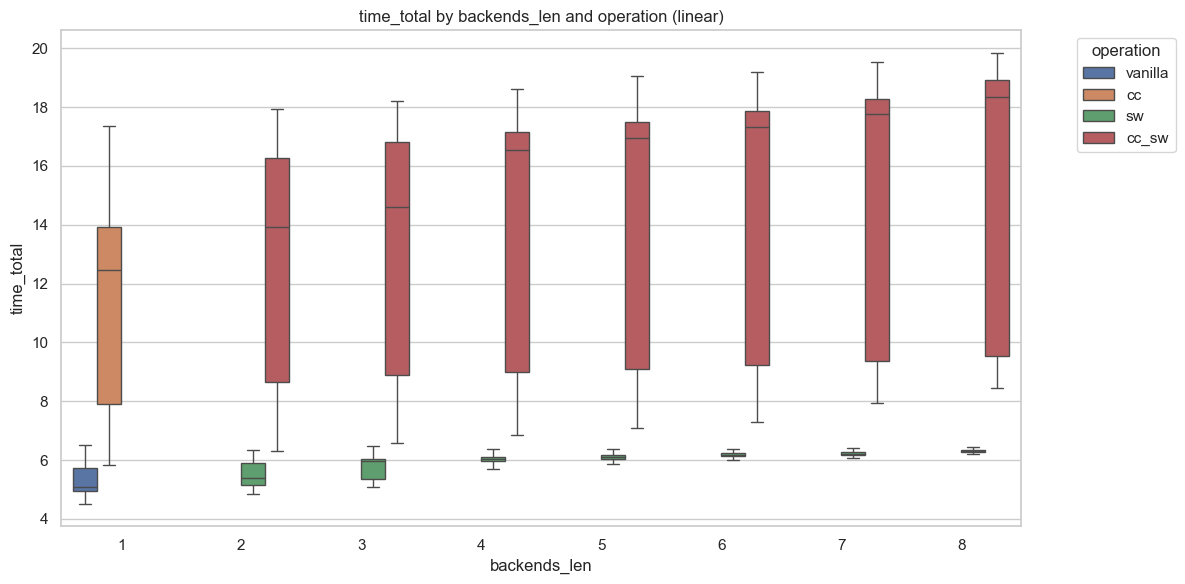

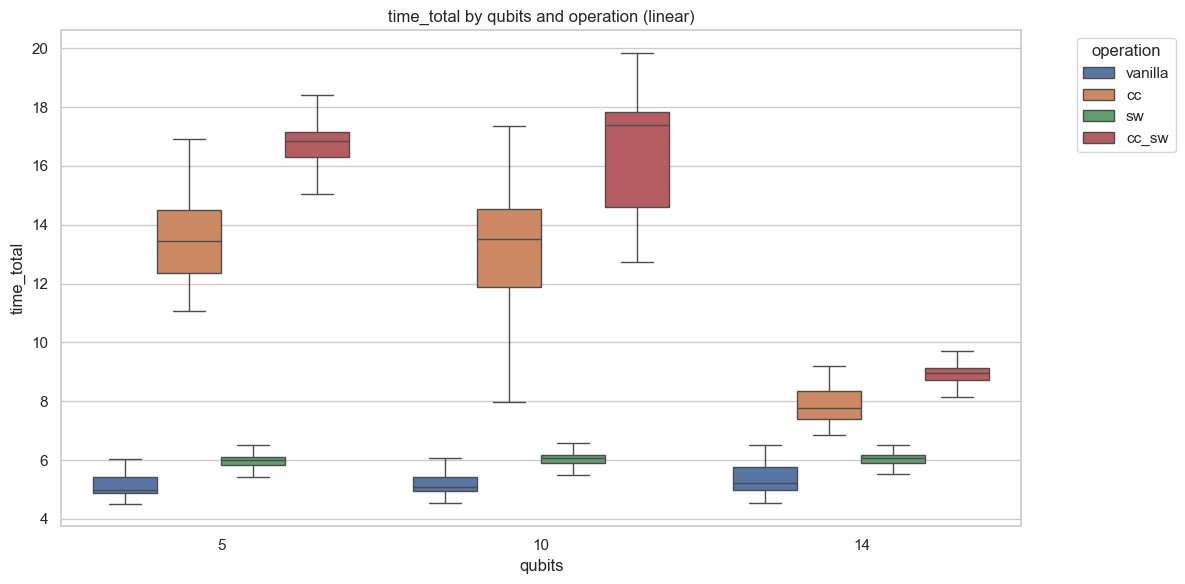

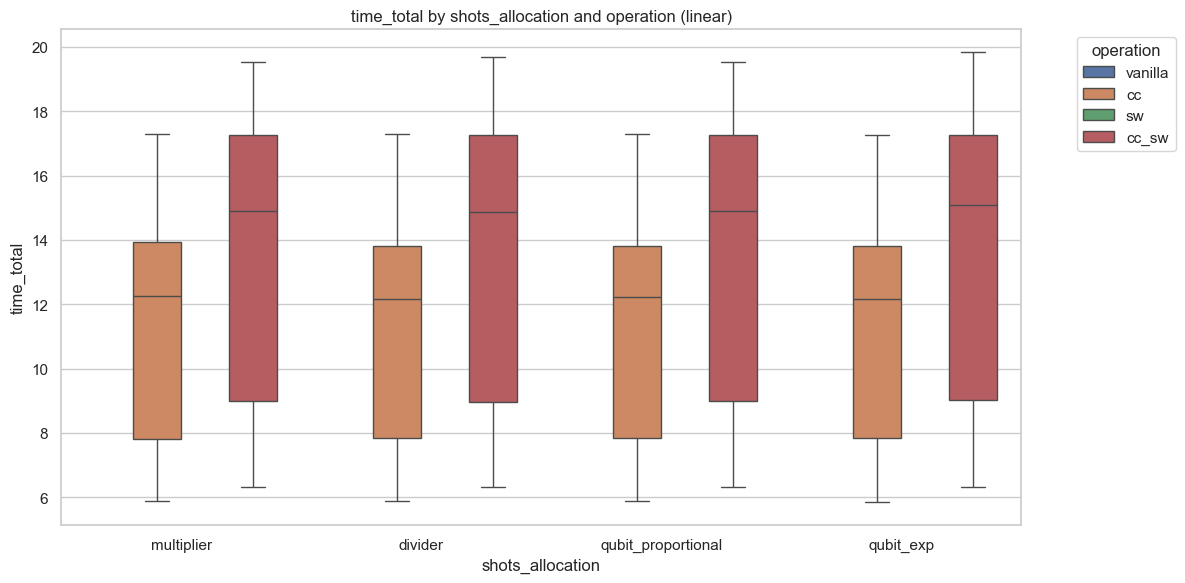

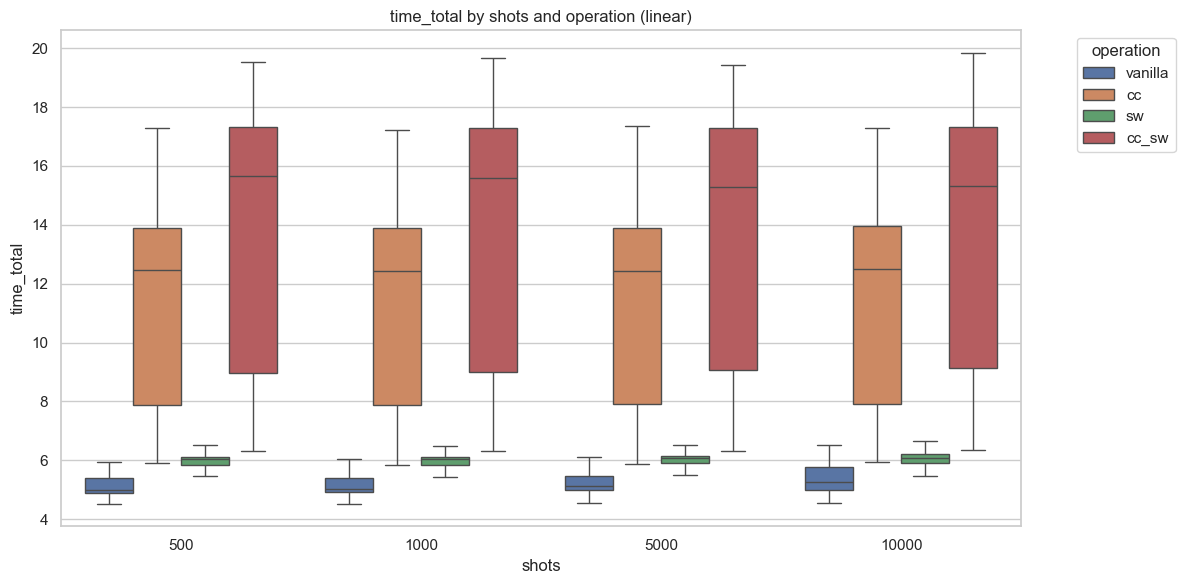

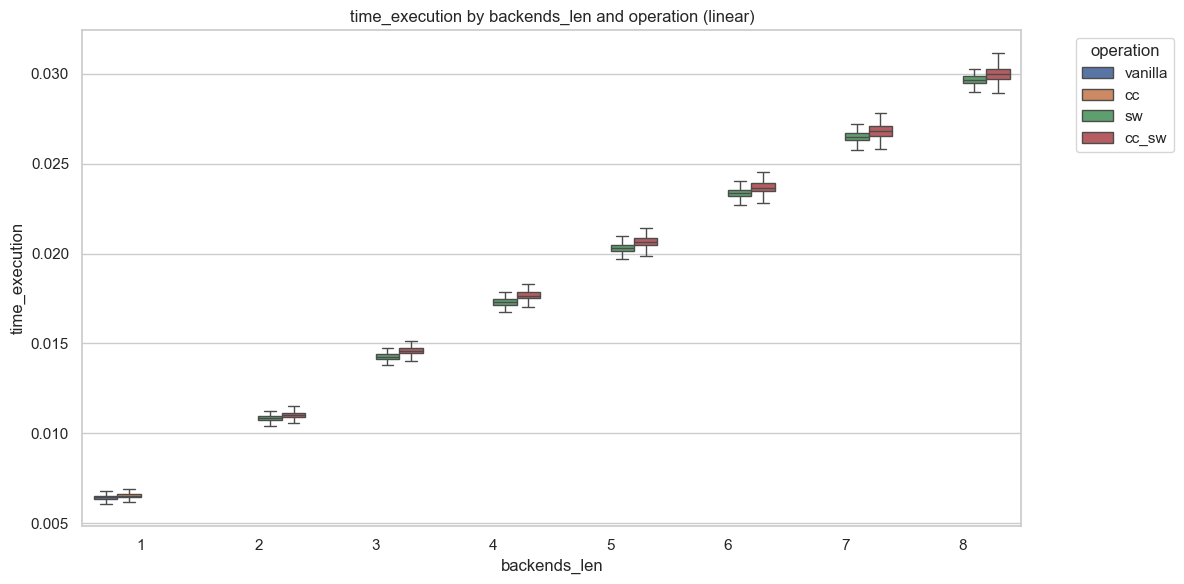

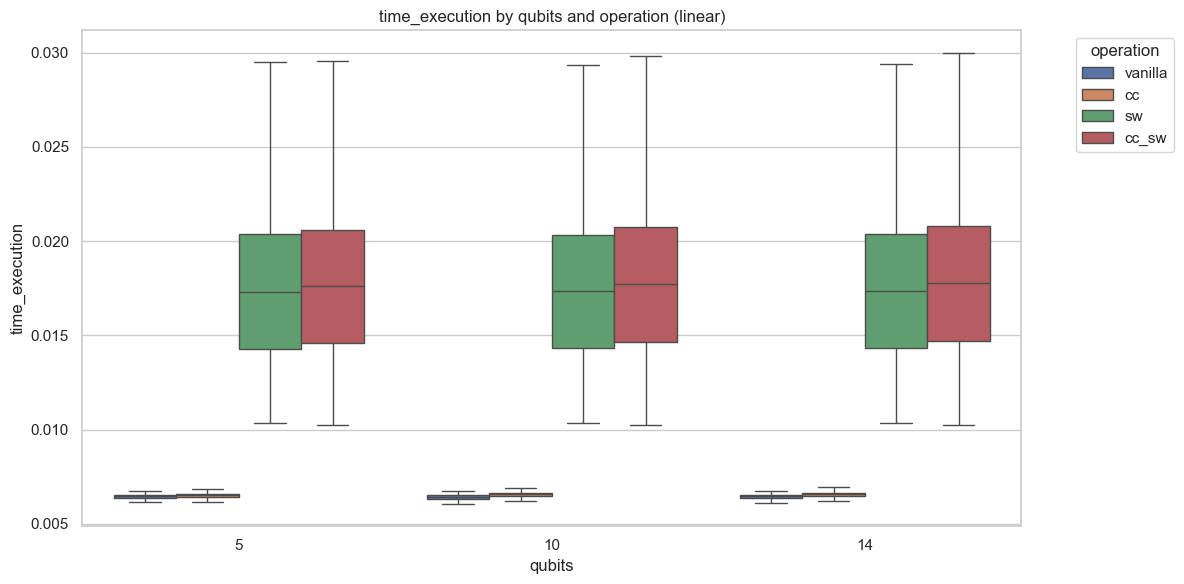

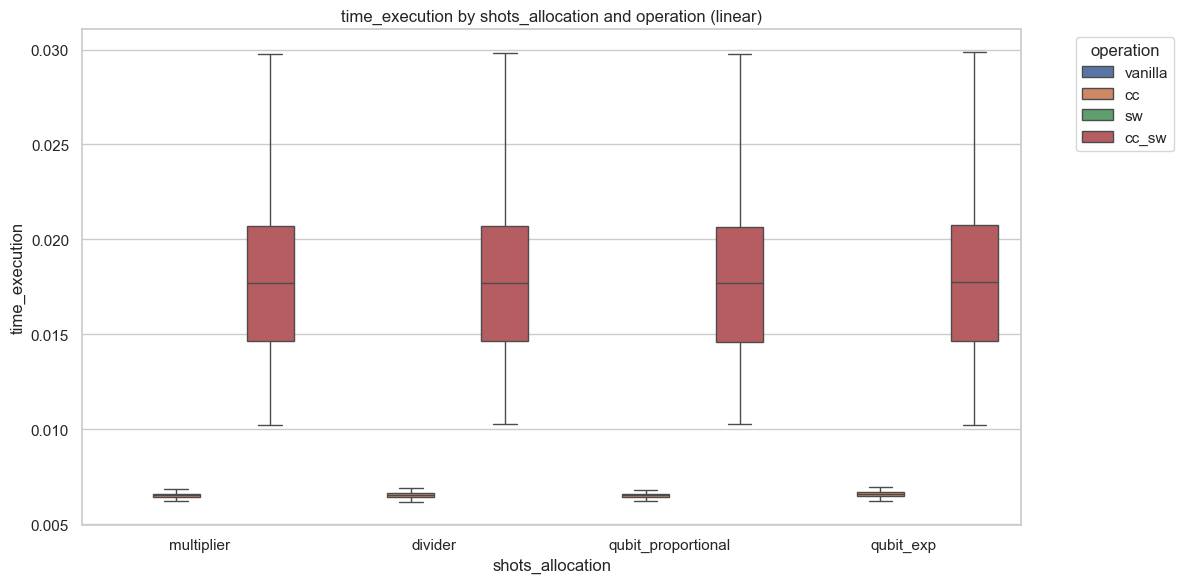

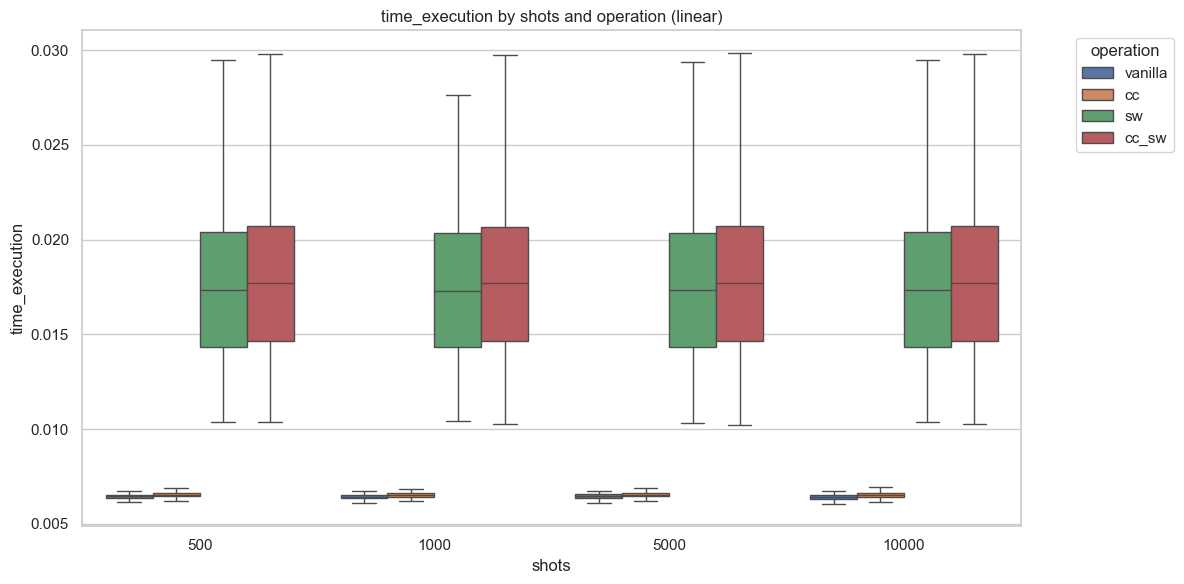

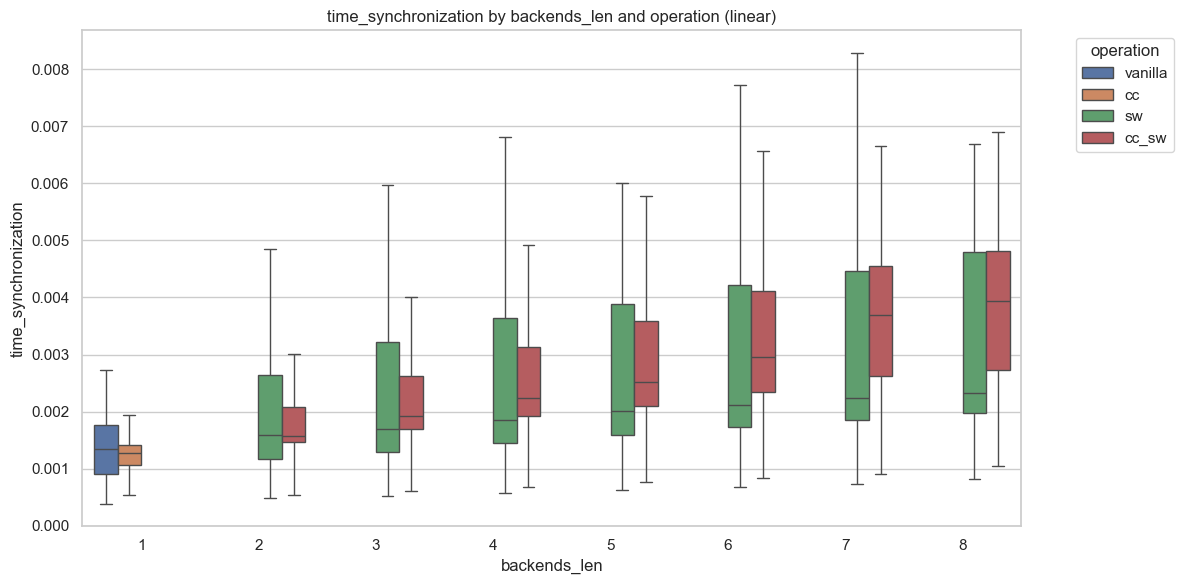

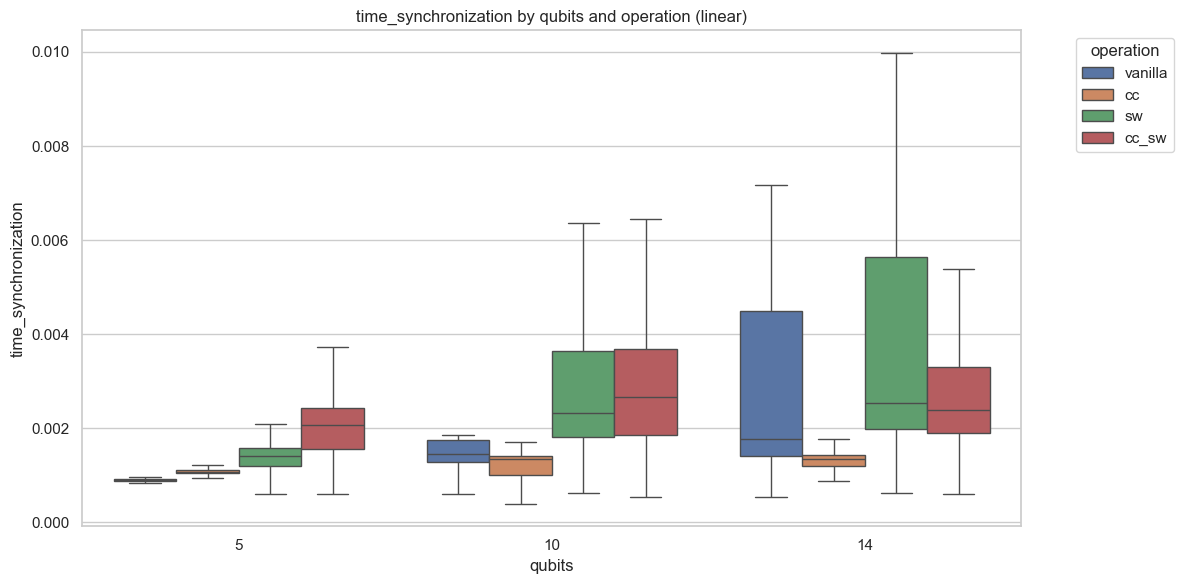

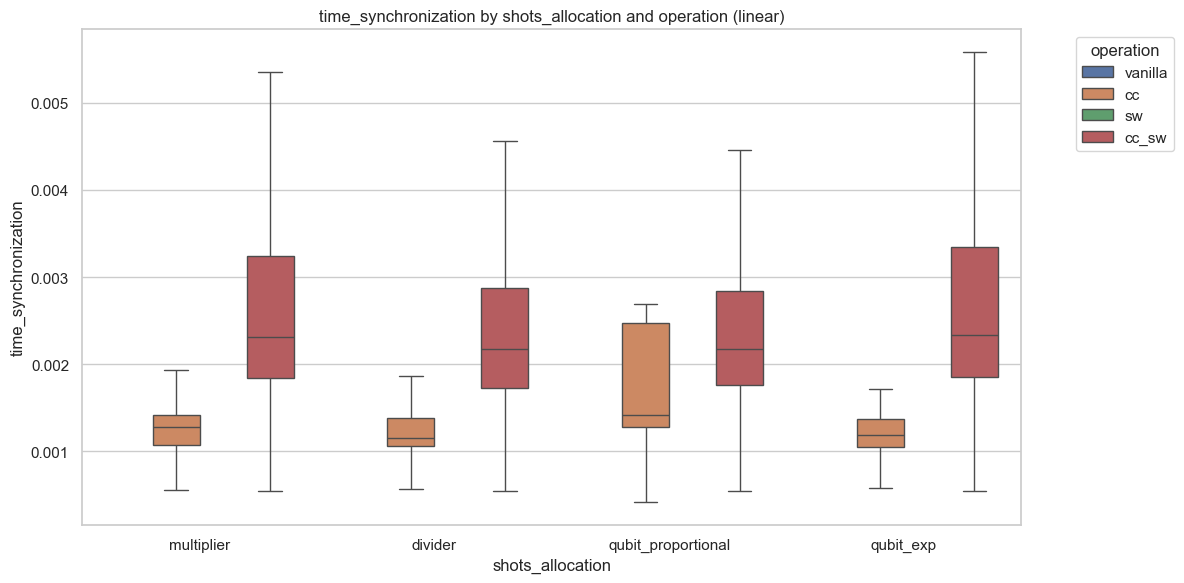

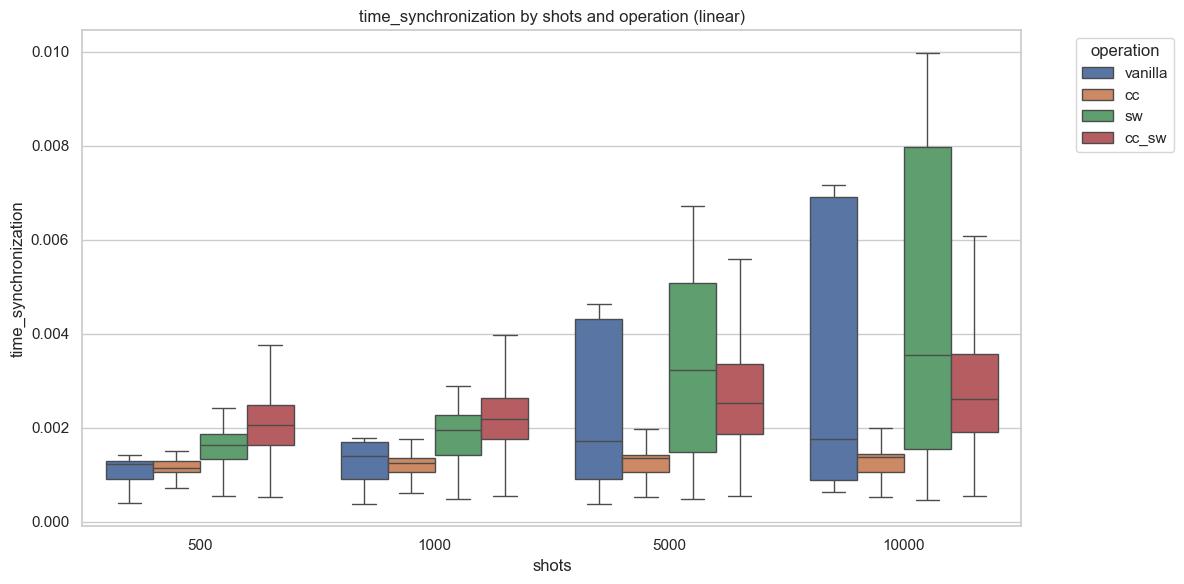

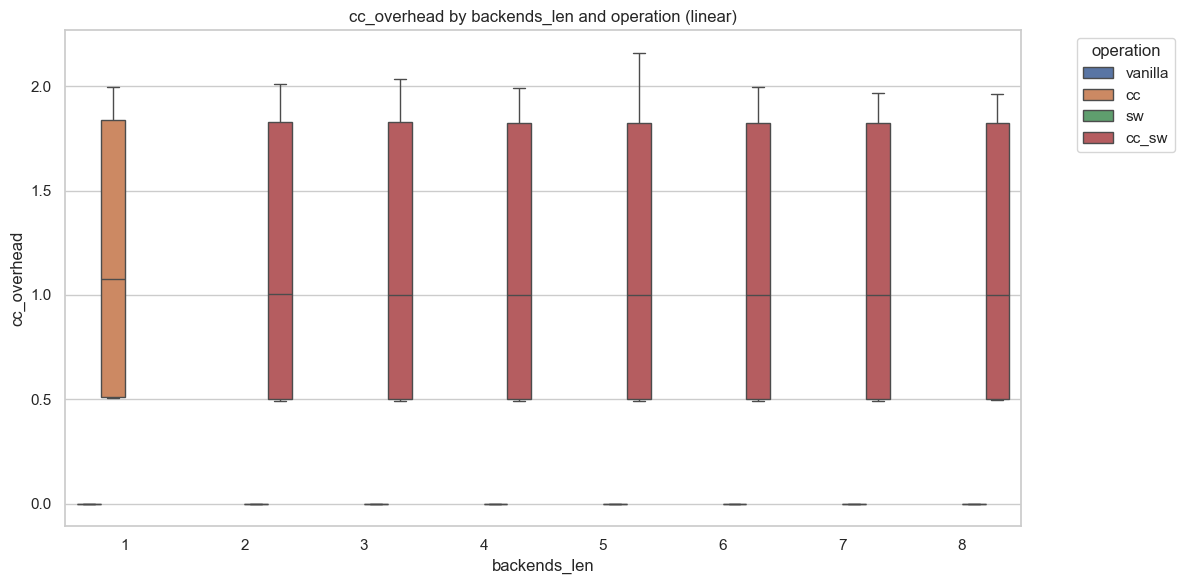

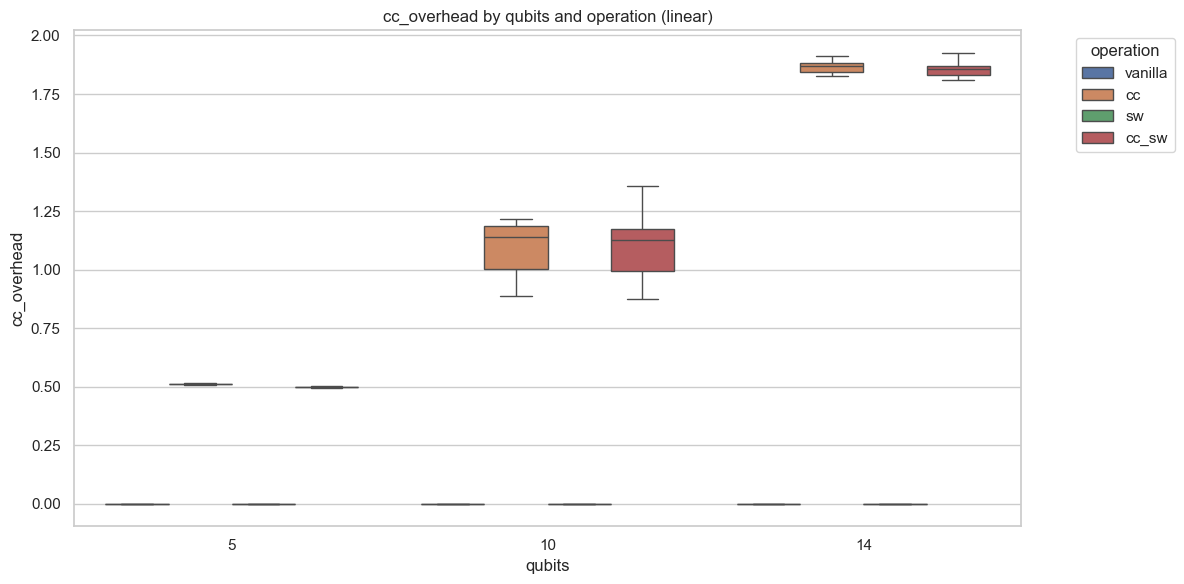

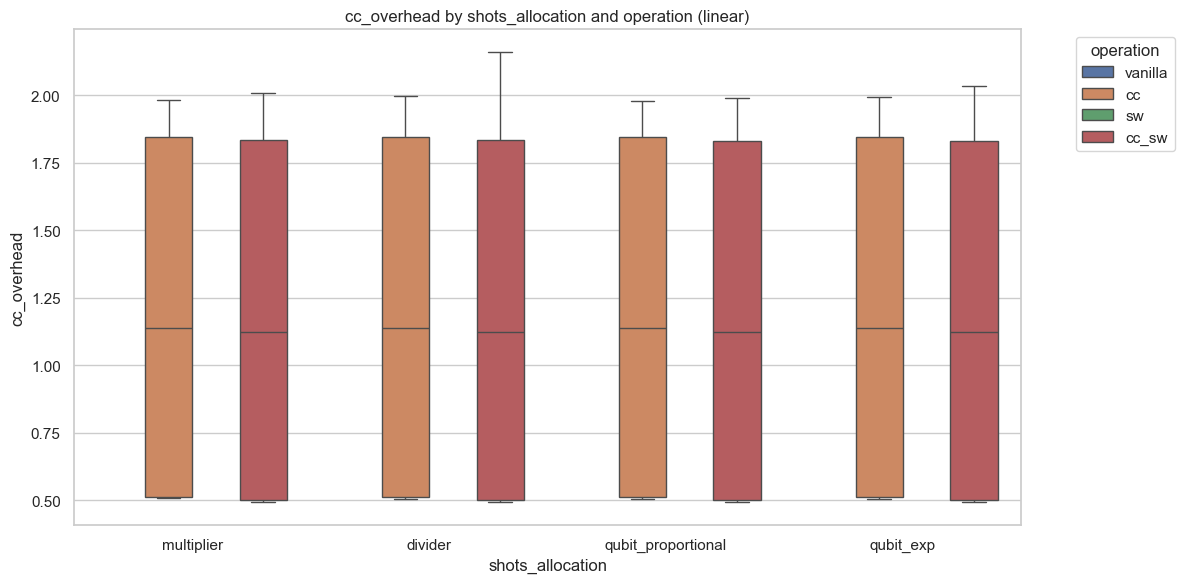

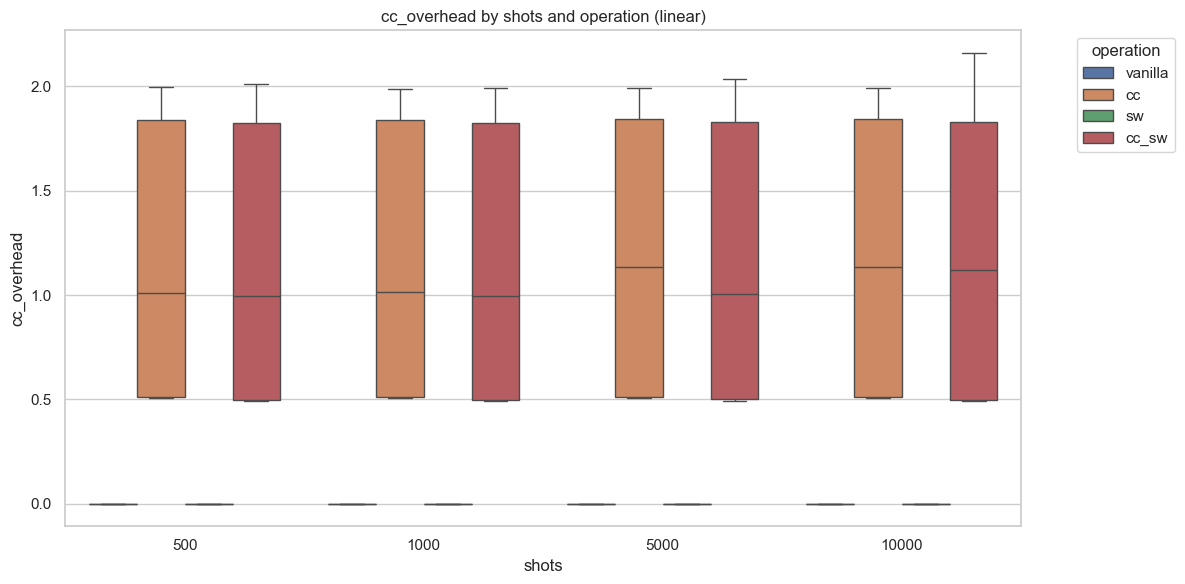

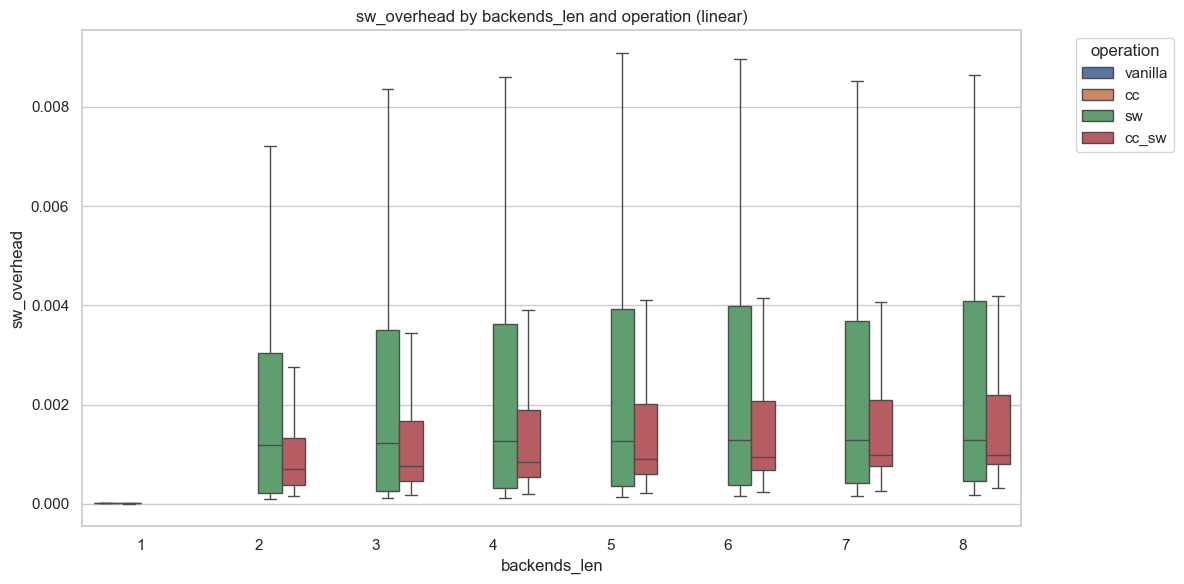

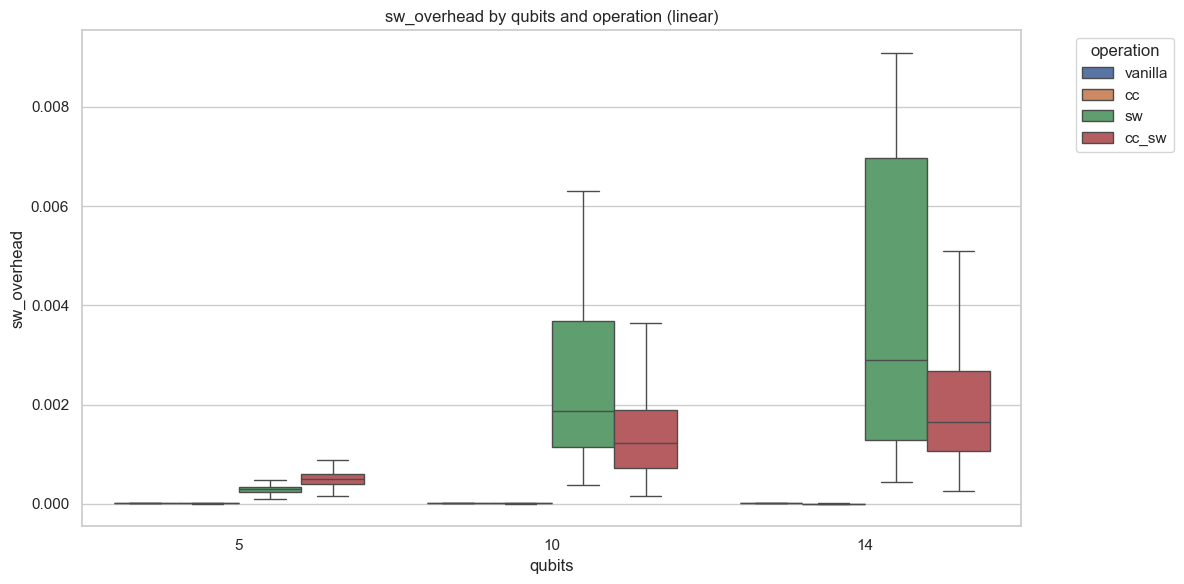

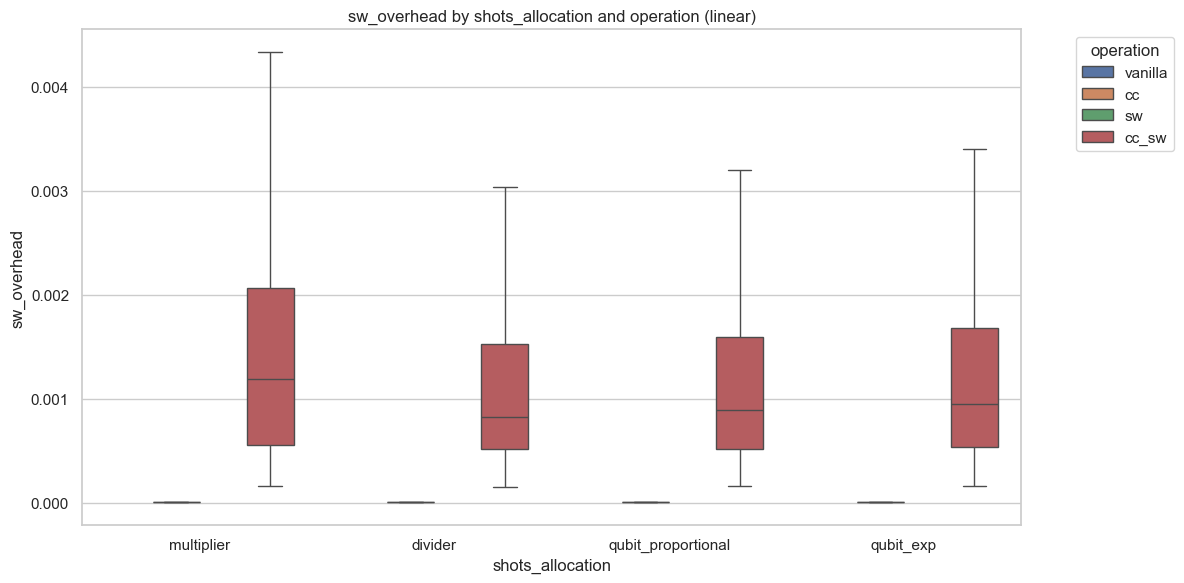

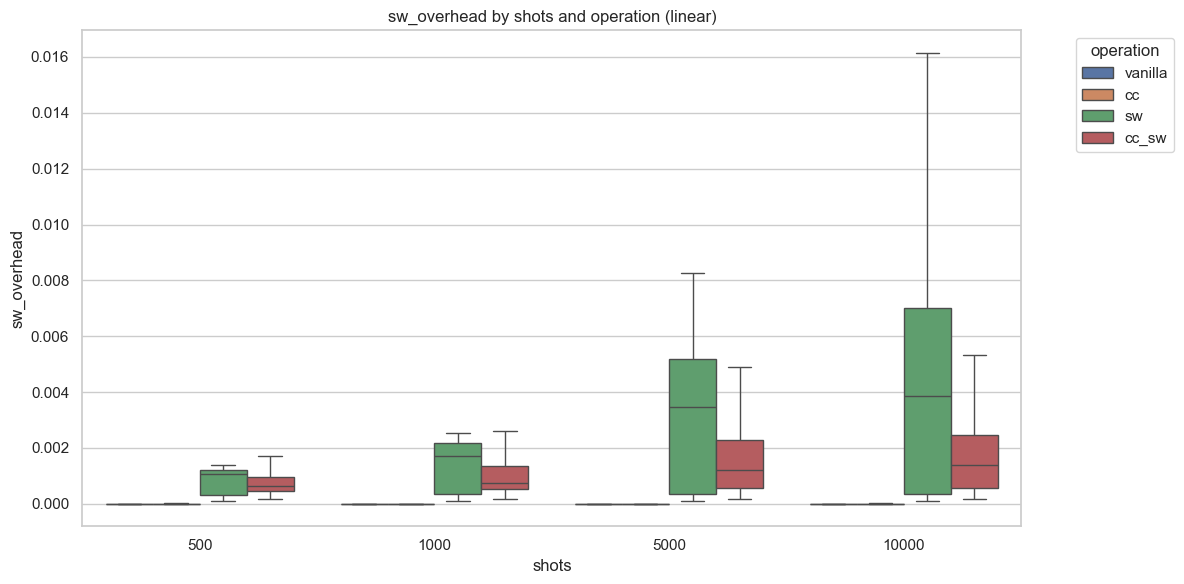

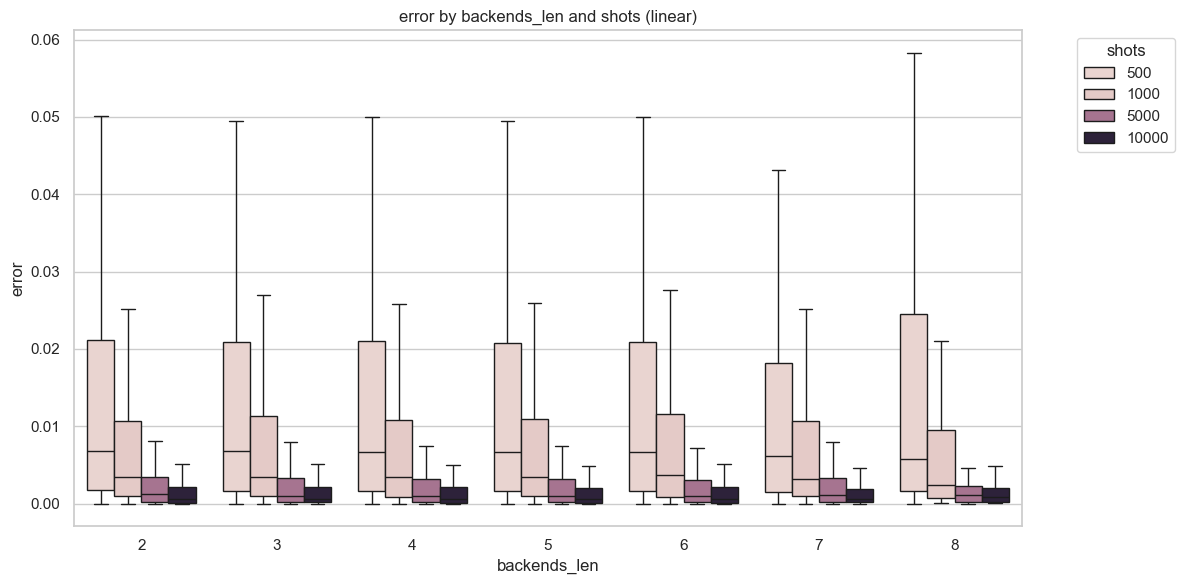

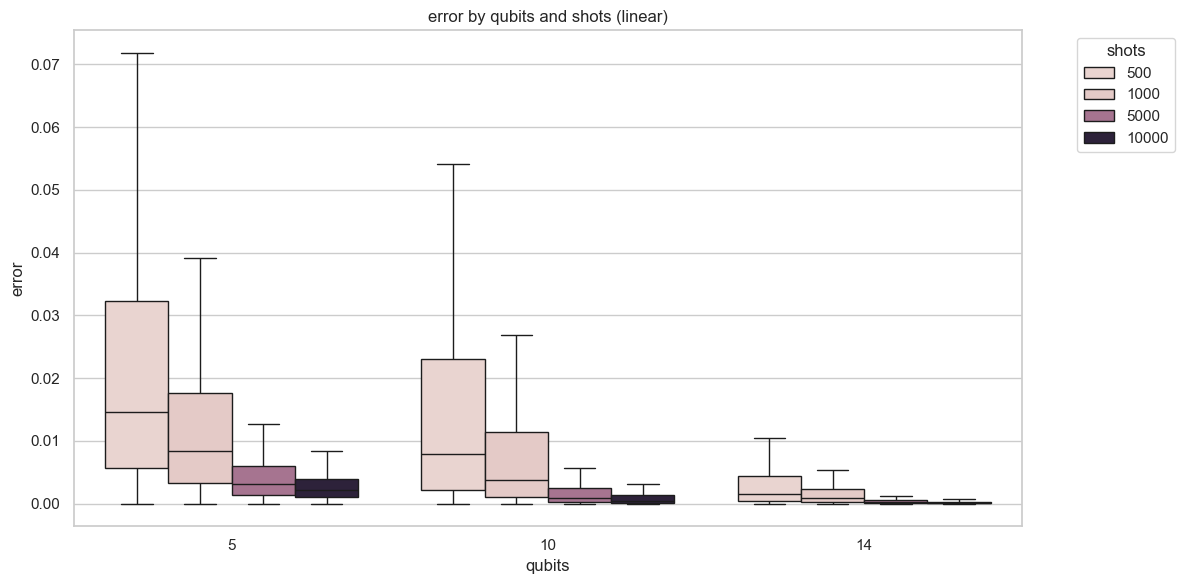

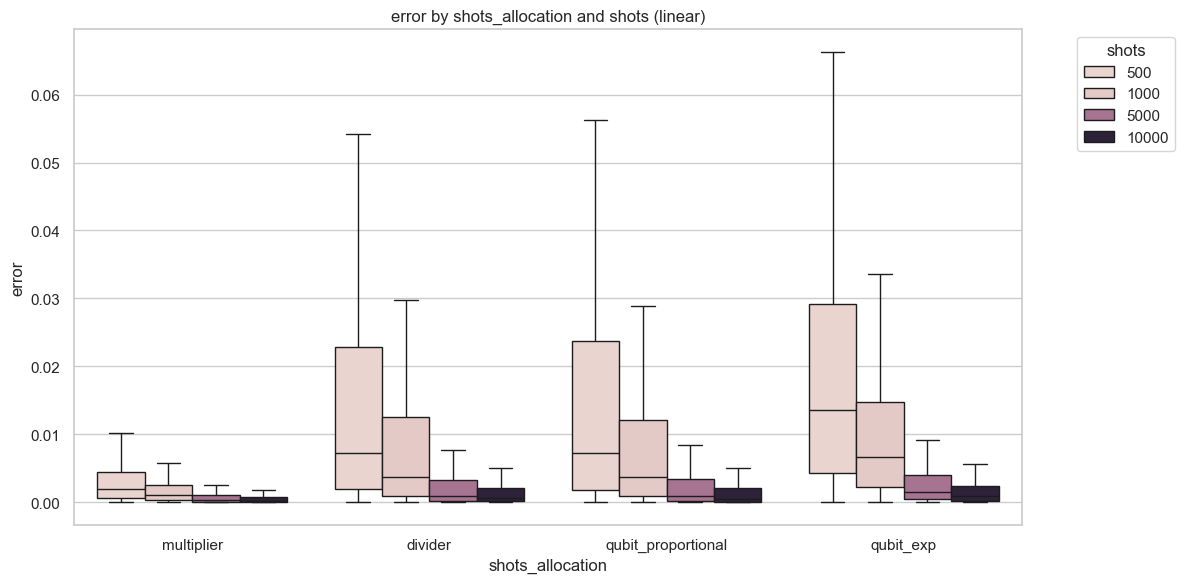

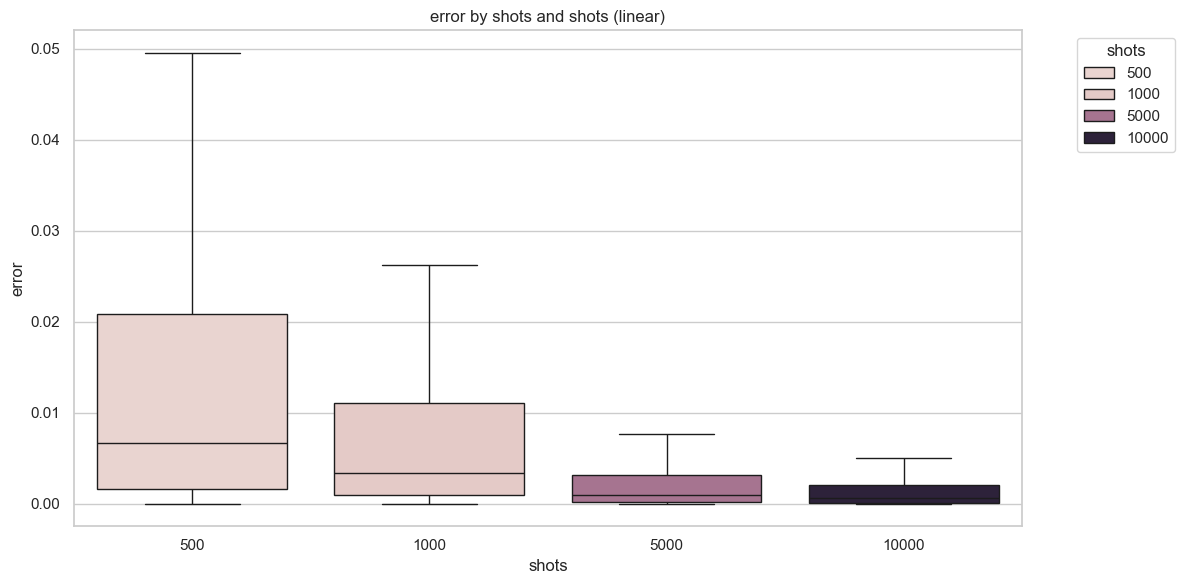

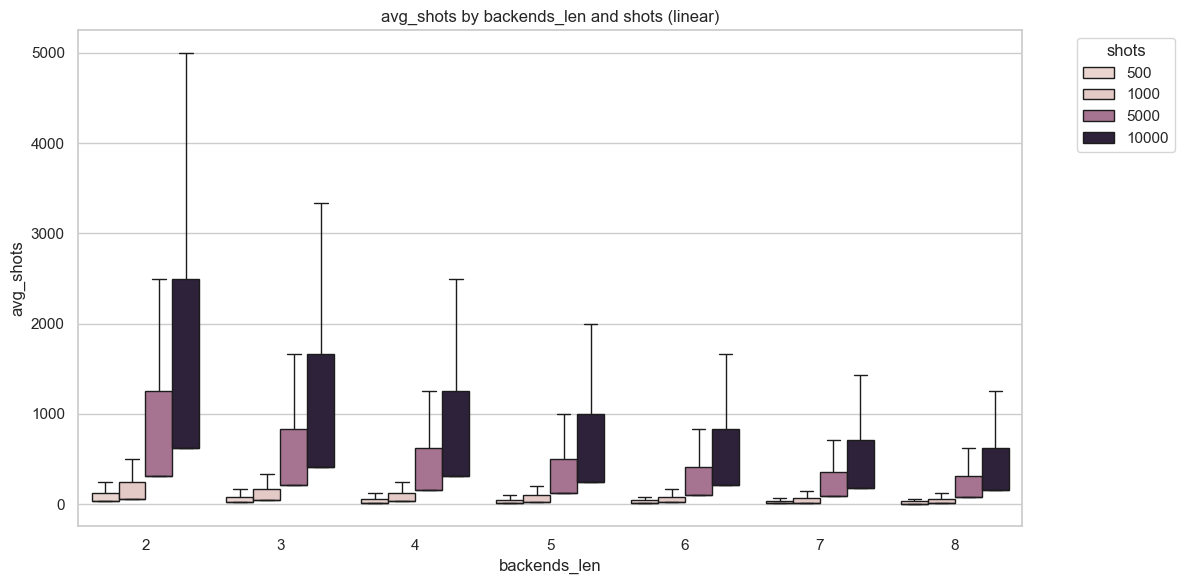

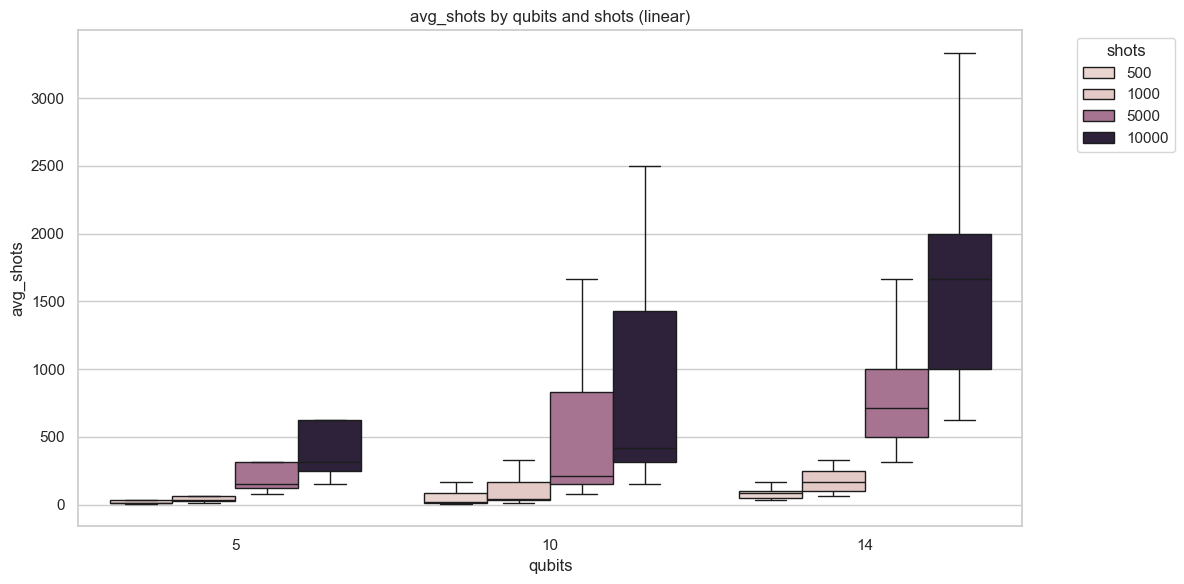

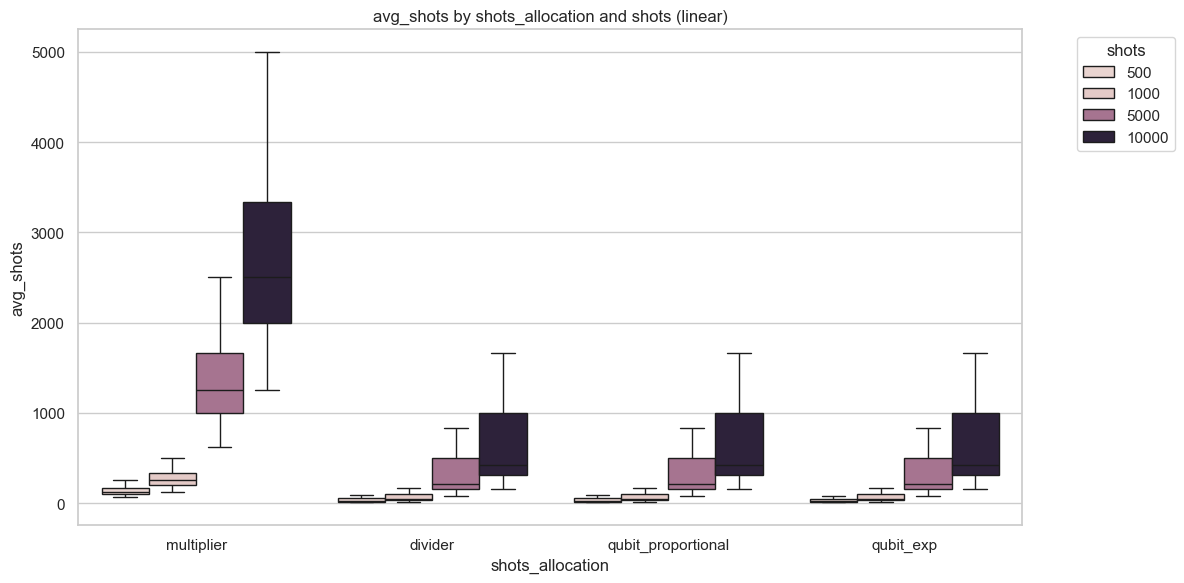

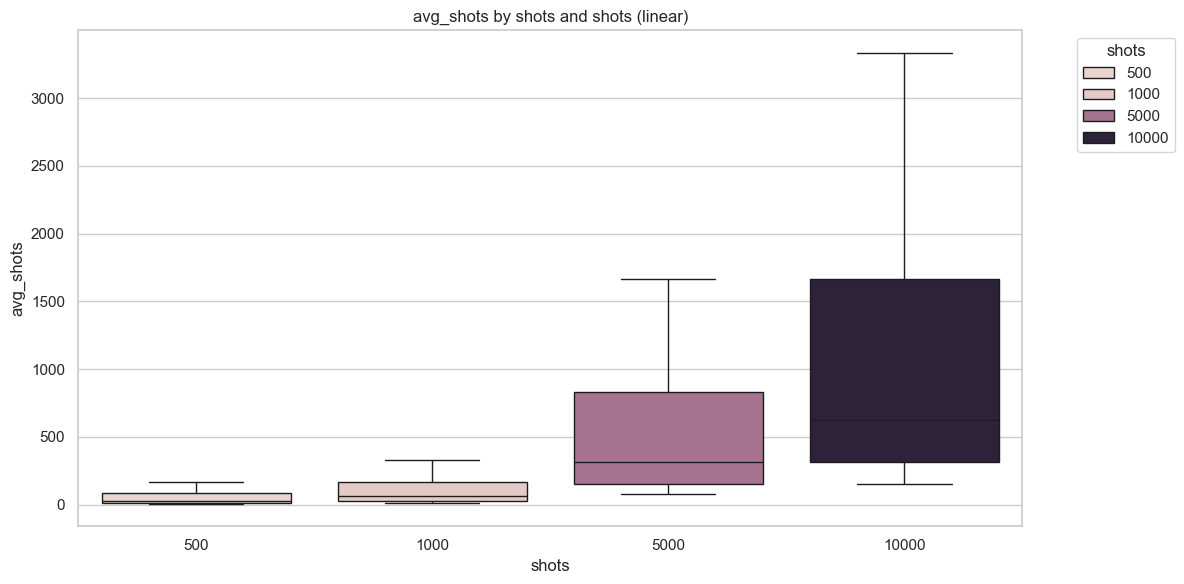

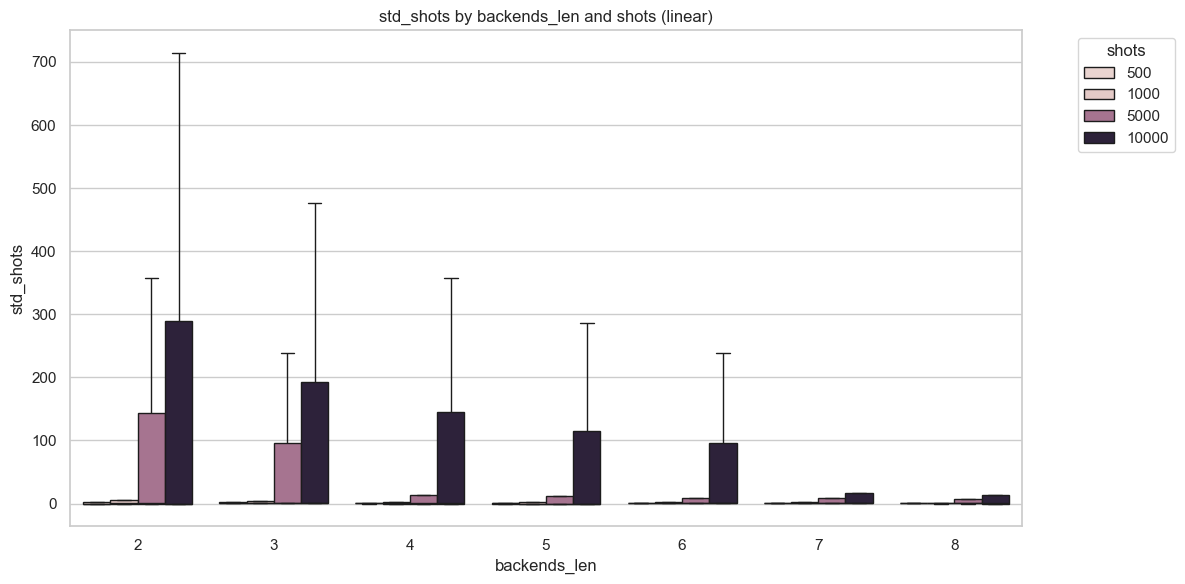

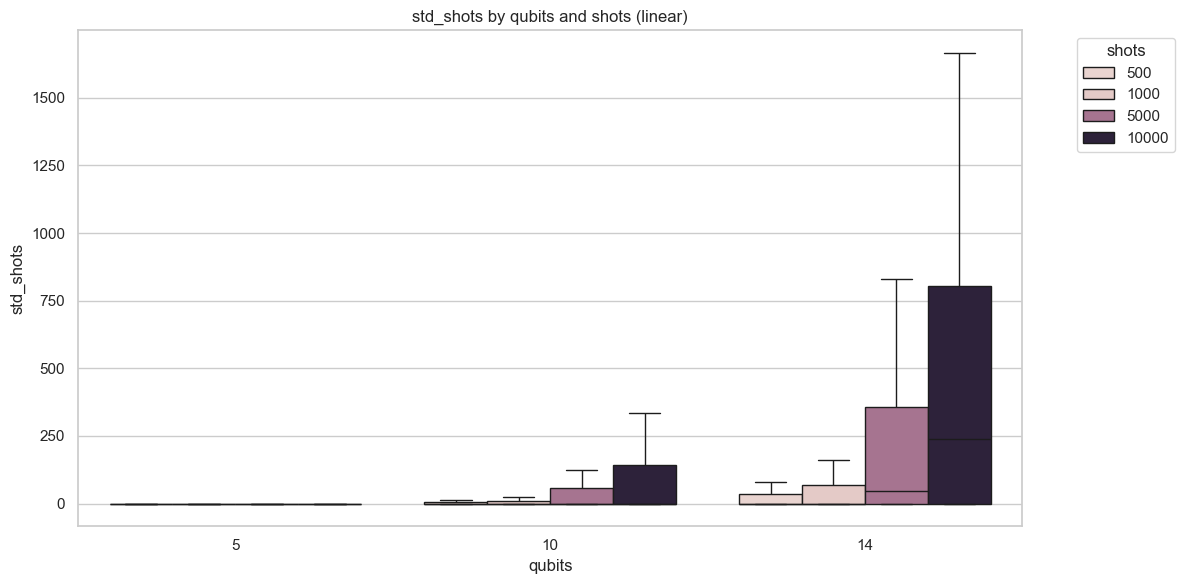

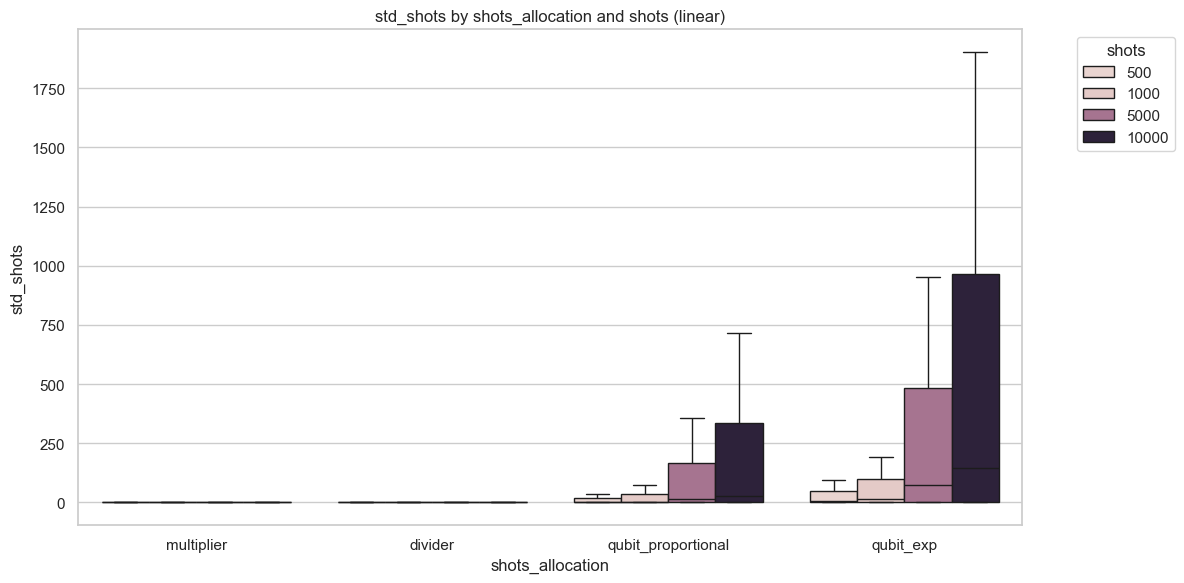

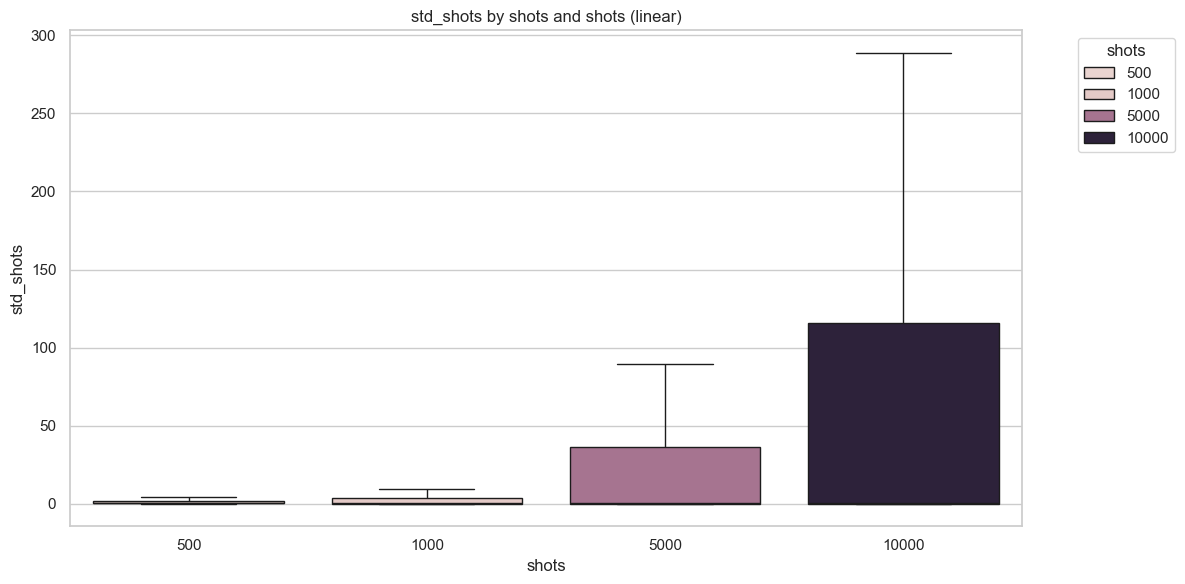

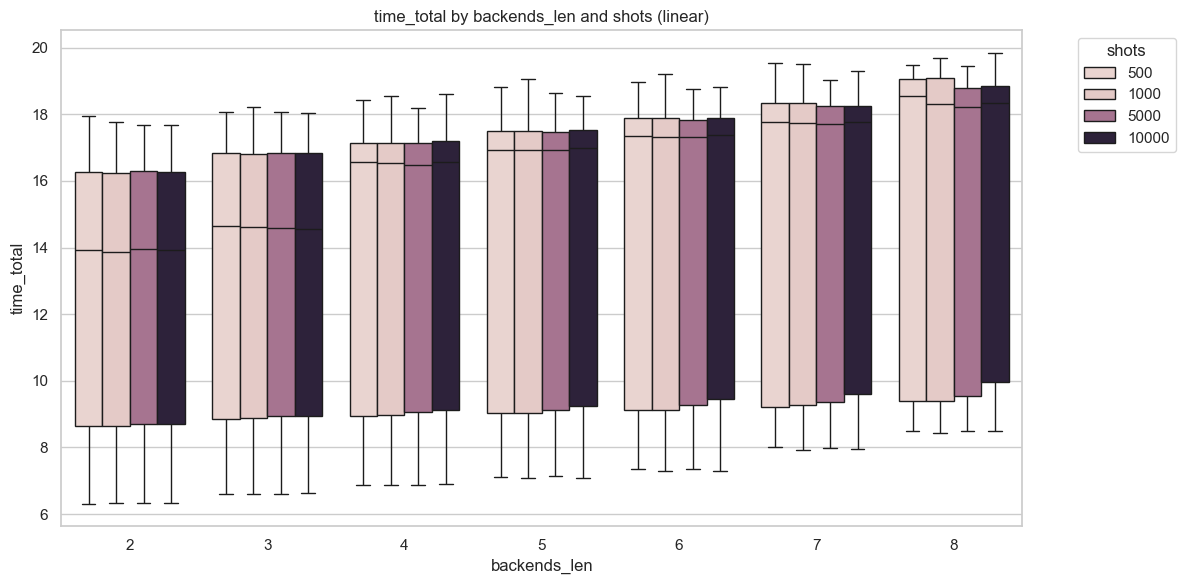

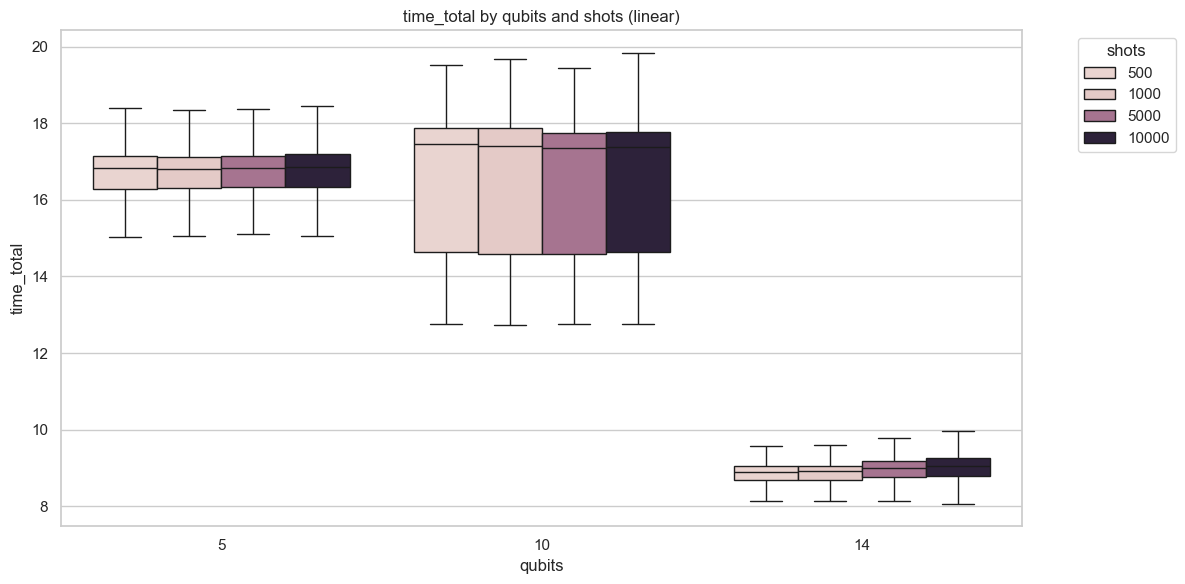

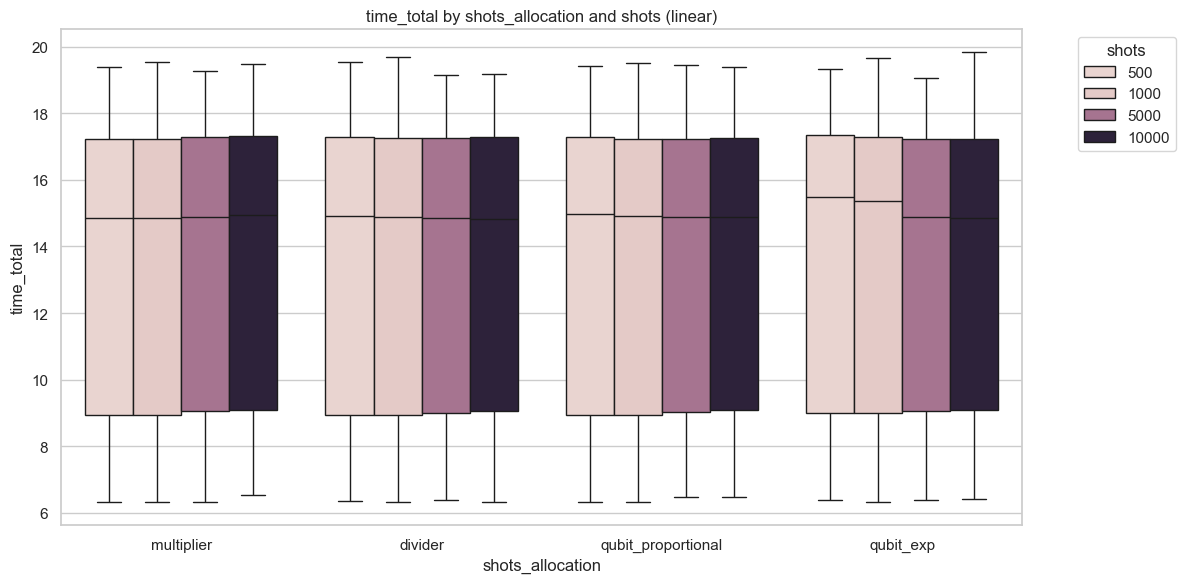

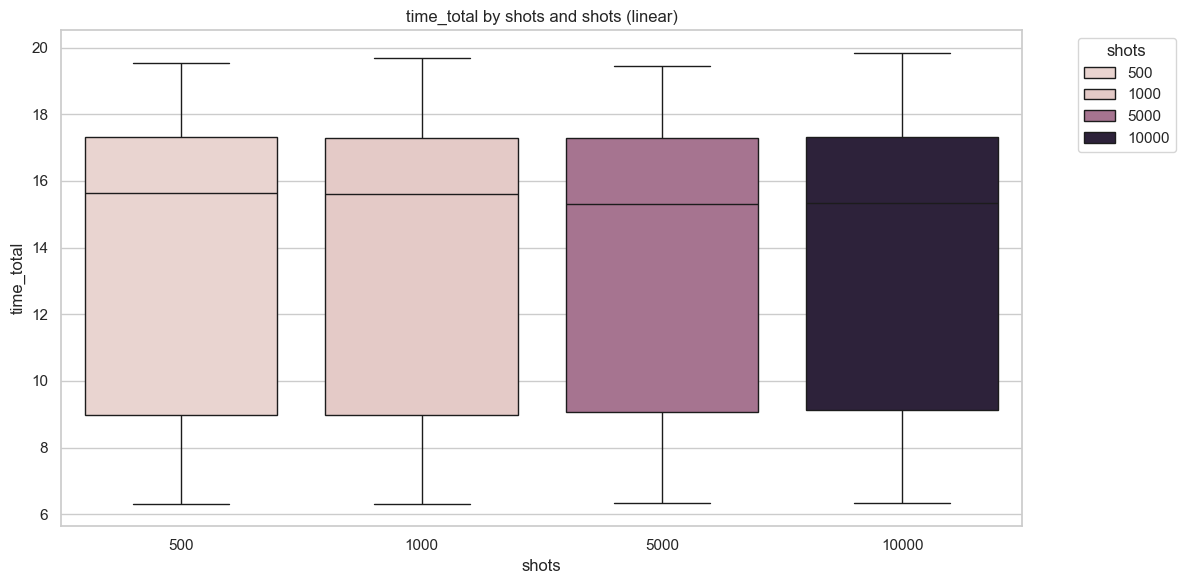

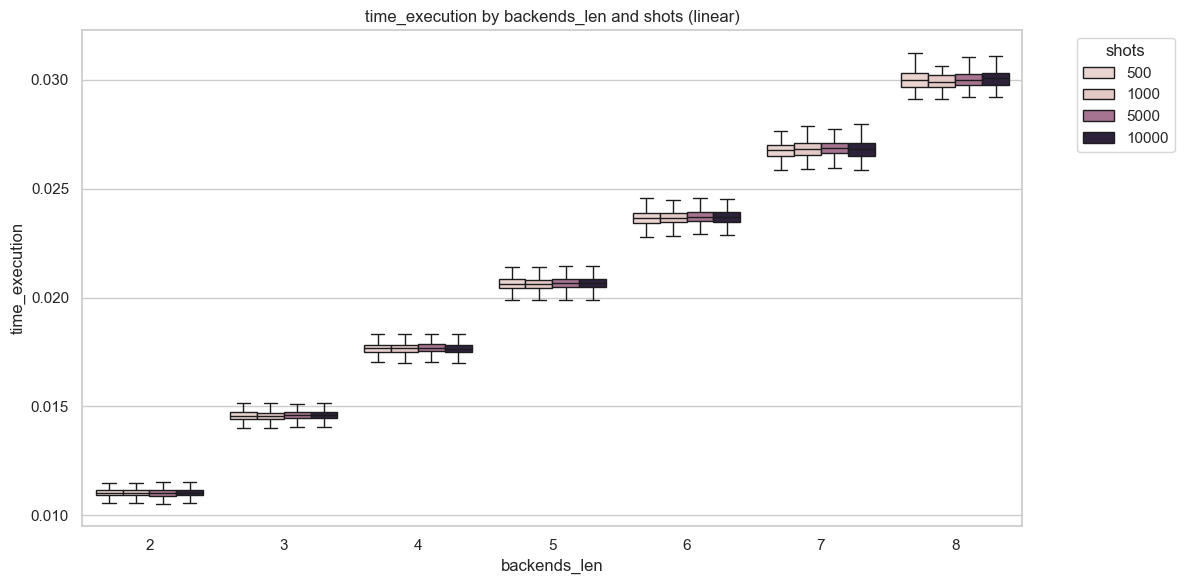

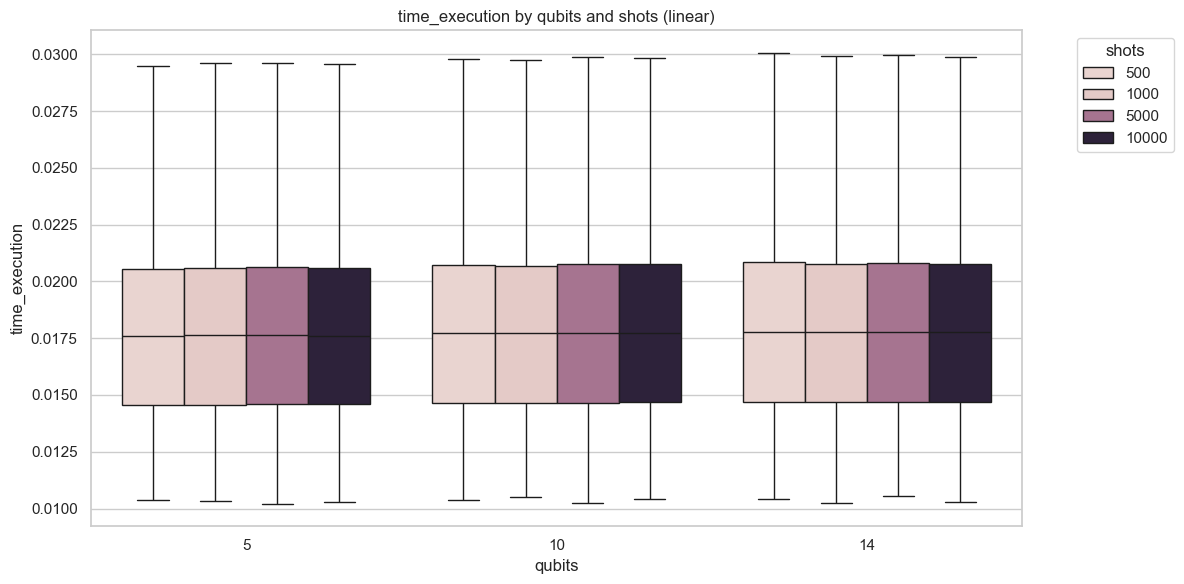

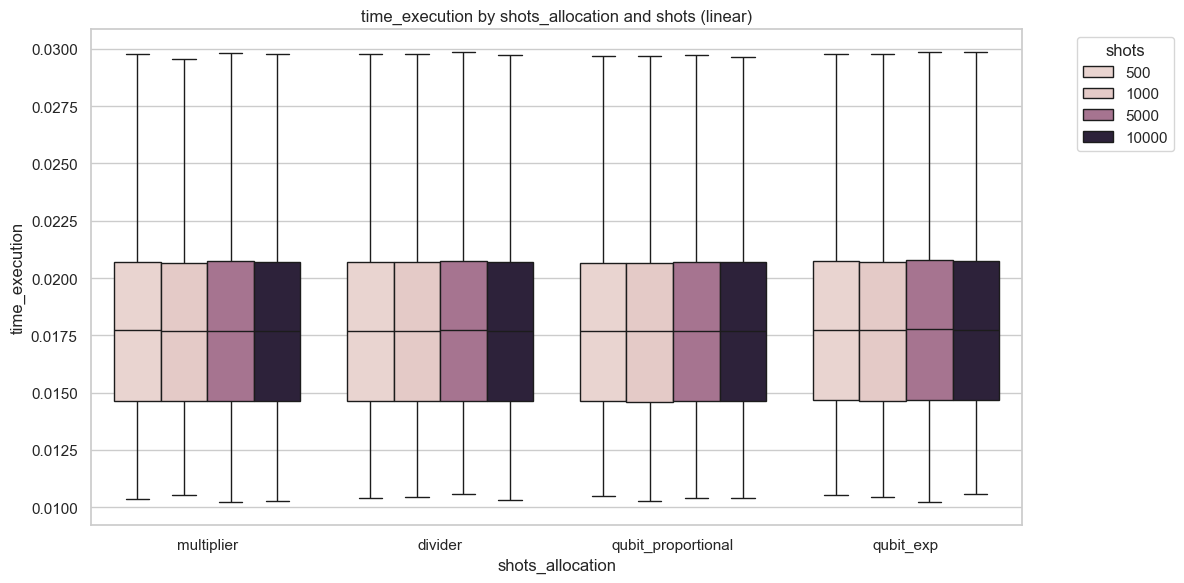

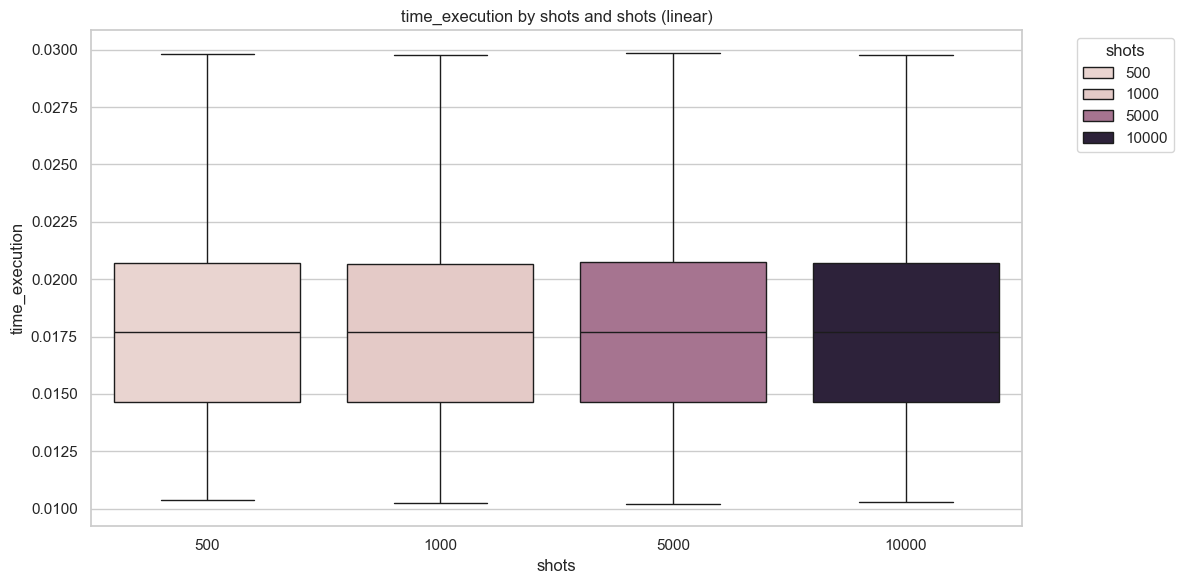

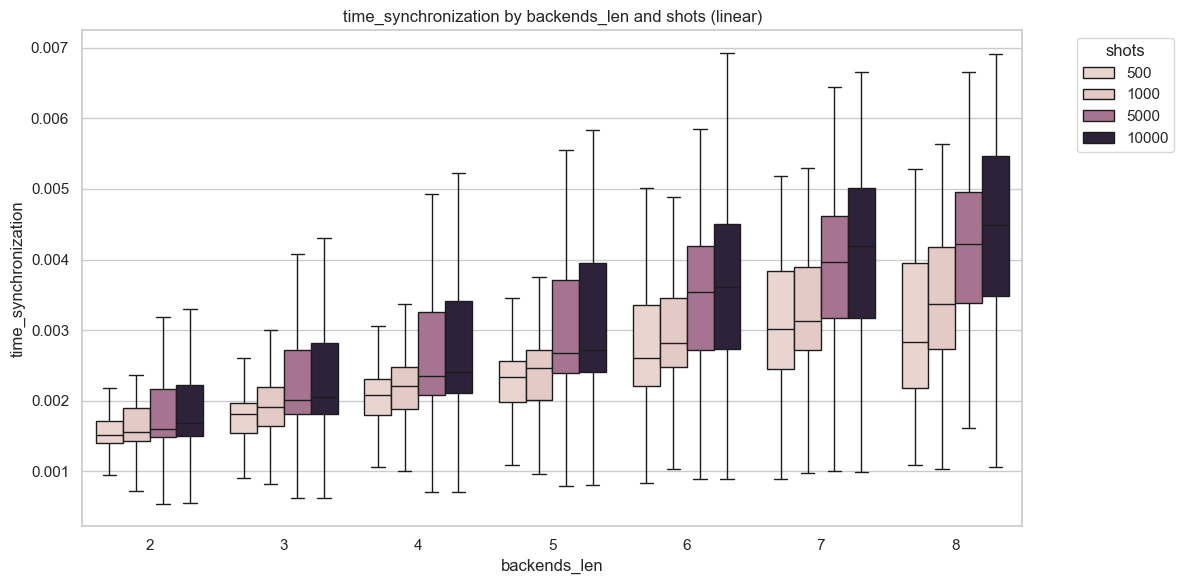

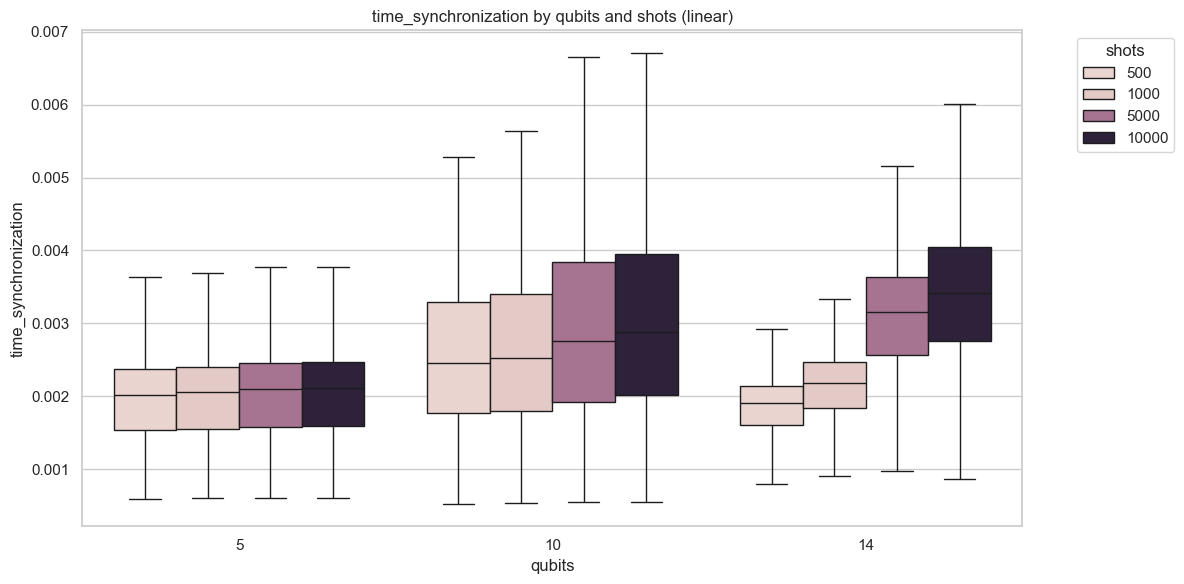

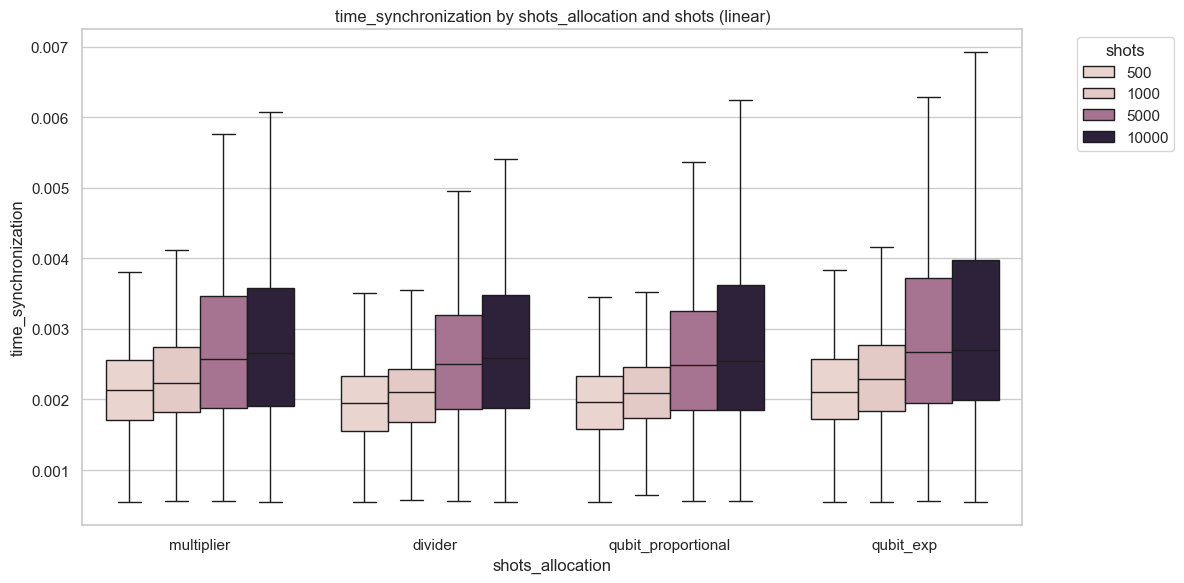

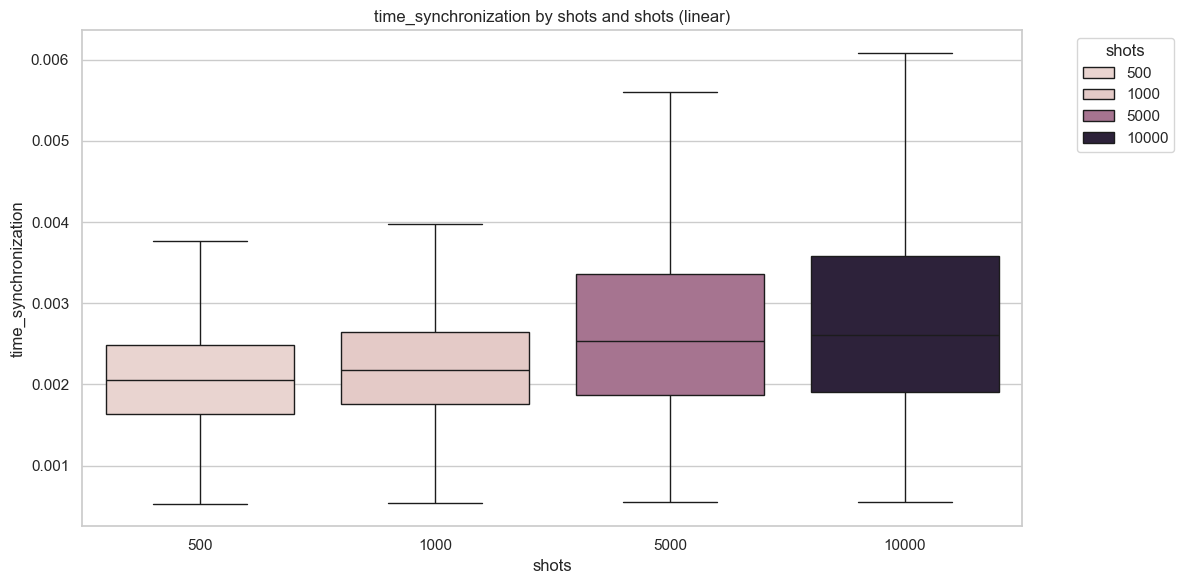

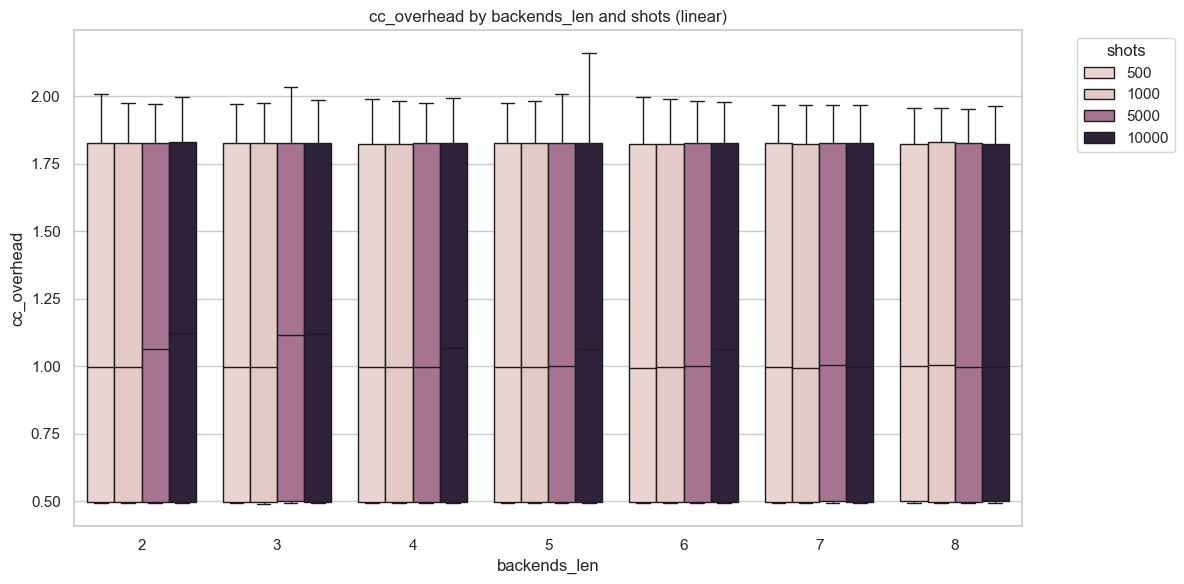

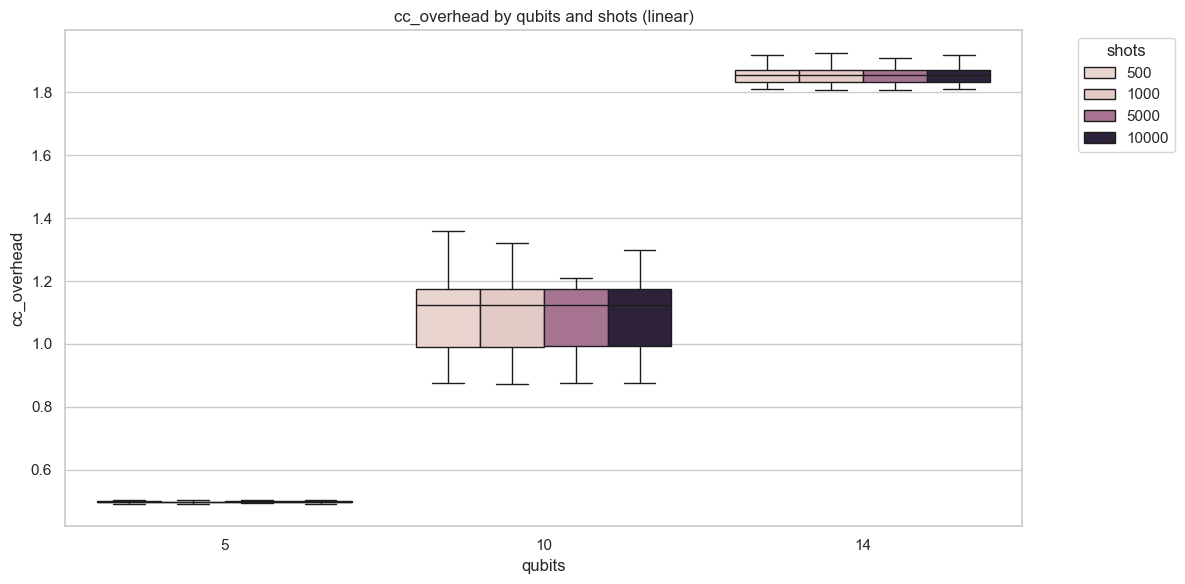

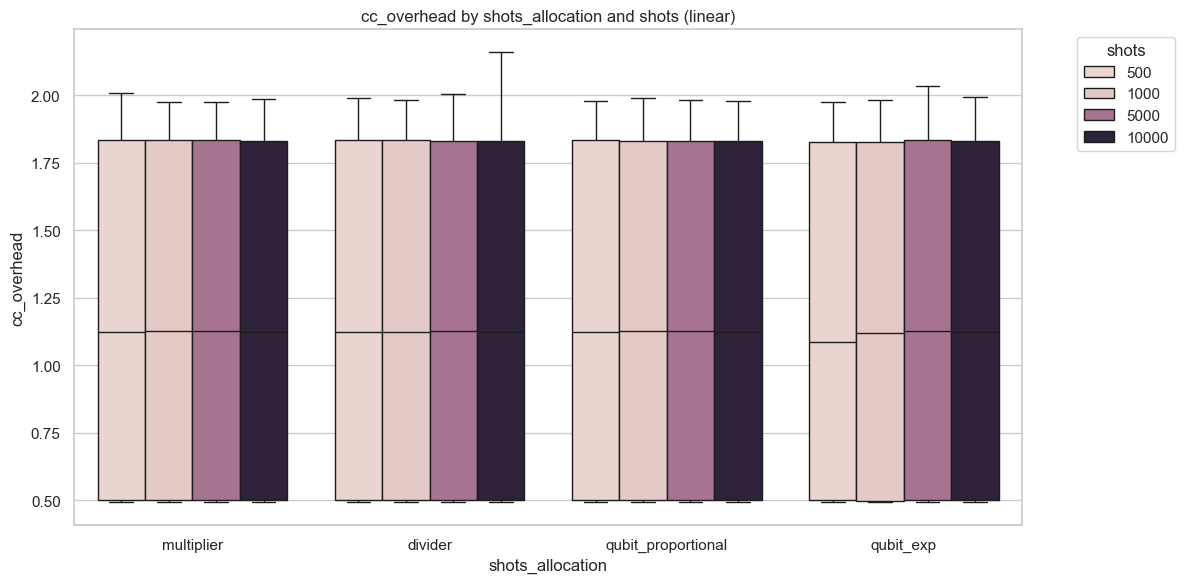

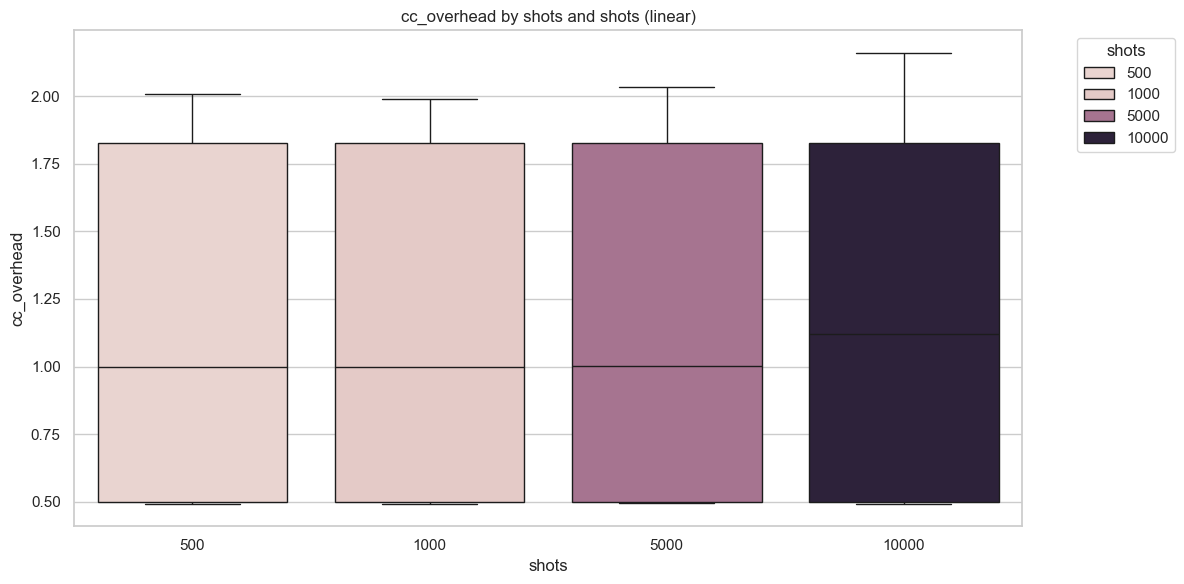

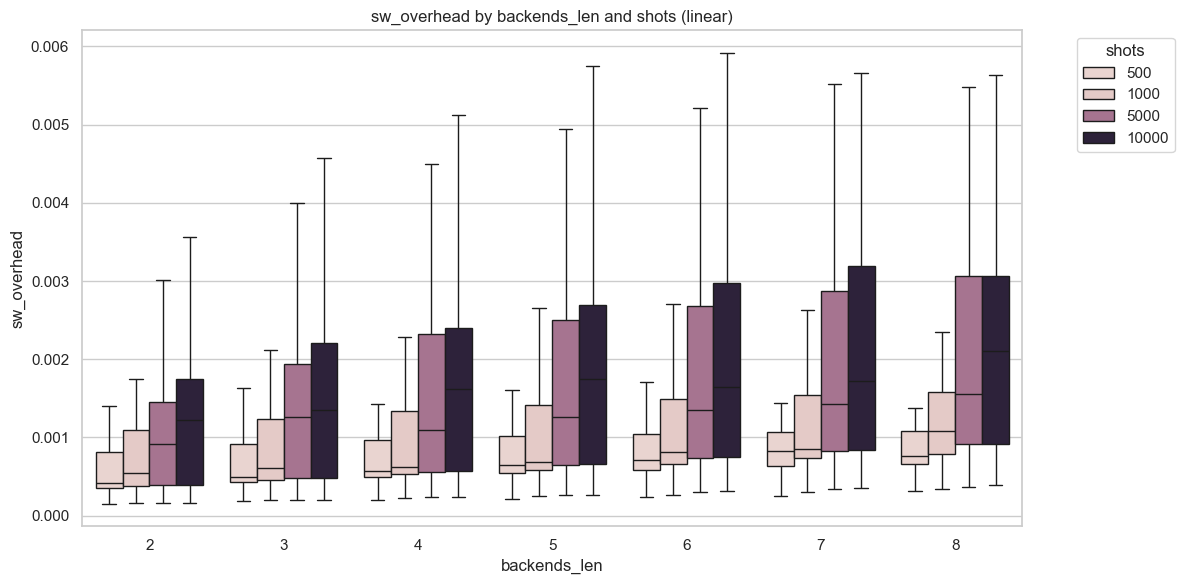

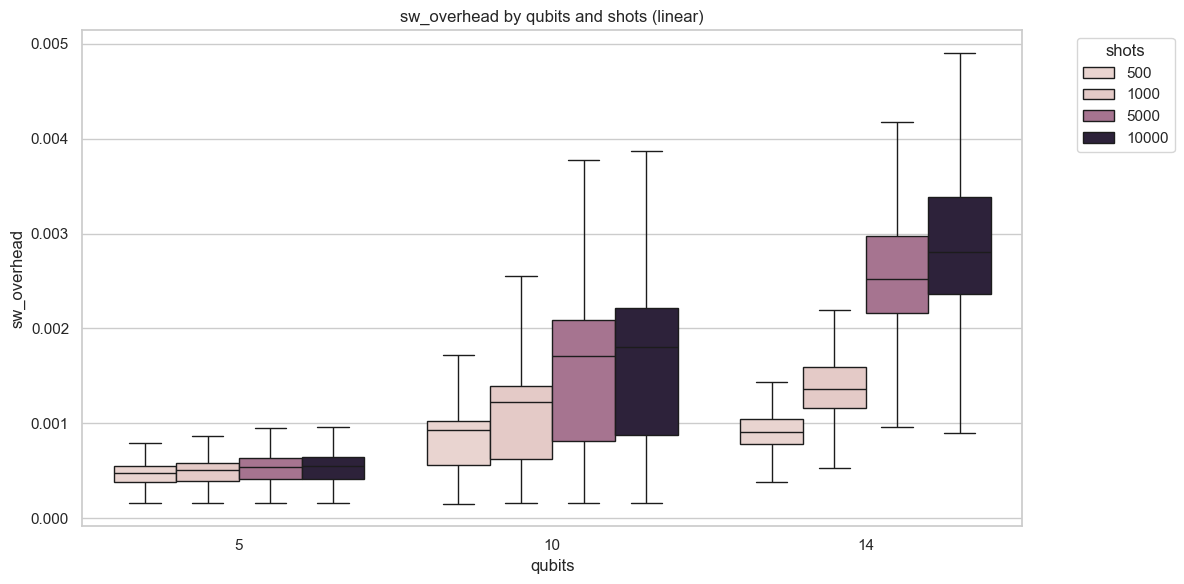

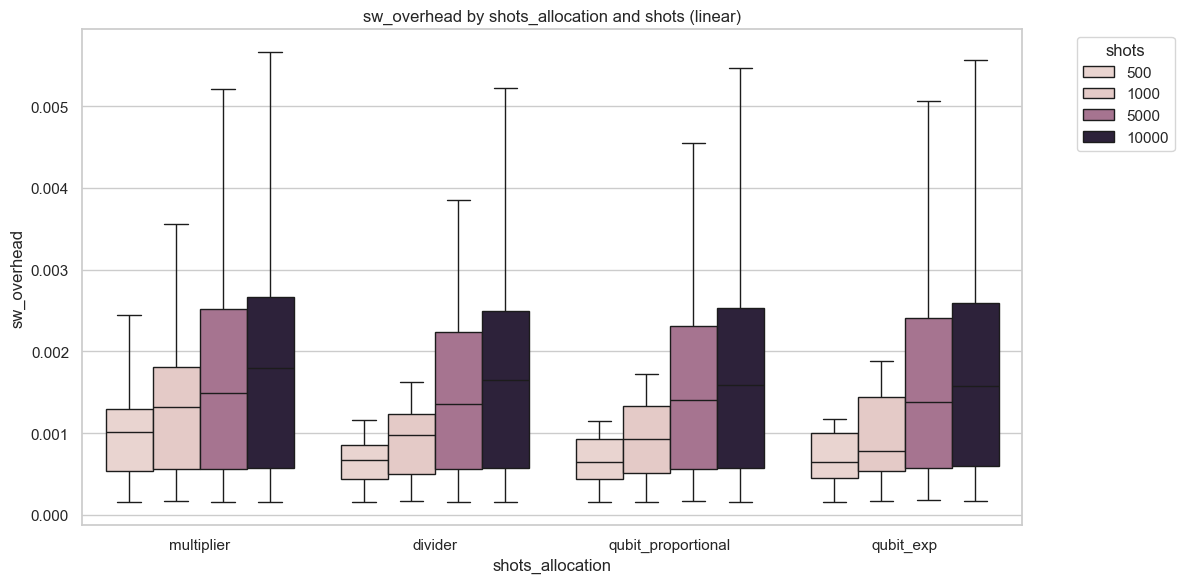

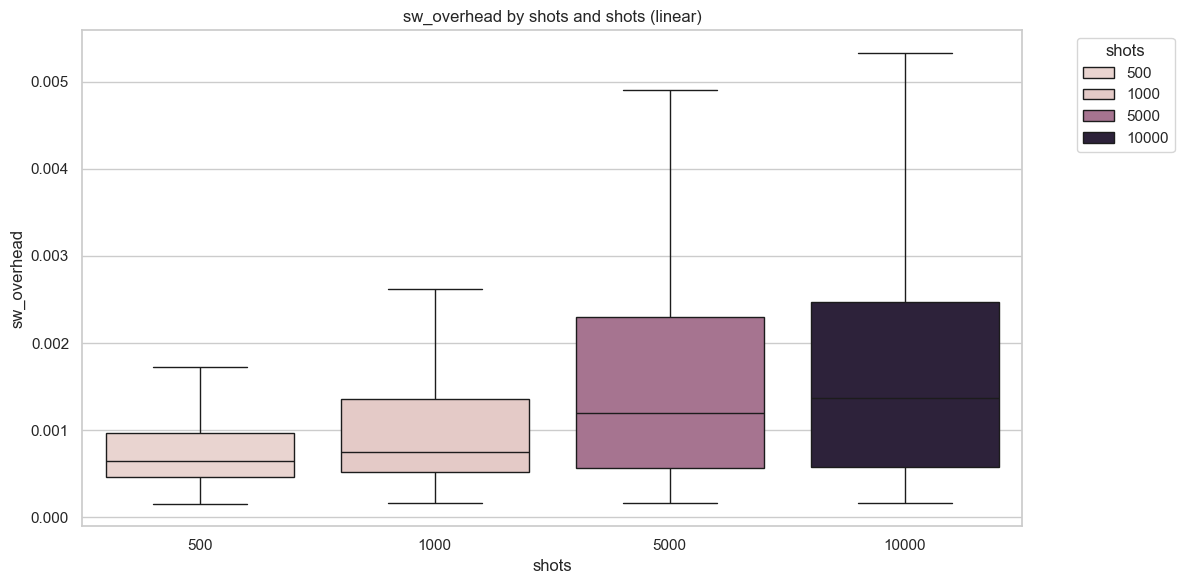

In [12]:

for style in styles:
    for hue_axis in hue_axes:
        for y_axis in y_axes:
            for x_axis in x_axes:
                
                # Set the visual style
                sns.set_theme(style="whitegrid")

                if hue_axis != "operation":
                    _df = df[df['operation'] == 'cc_sw']
                else:
                    _df = df

                # Create the boxplot
                plt.figure(figsize=(12, 6))
                if x_axis != "shots_allocation":
                    #sort as int
                    sns.boxplot(x=x_axis, y=y_axis, hue=hue_axis, data=_df, showfliers=False, order=_df[x_axis].sort_values(key=lambda x: x.astype(int)).unique())
                else:
                    sns.boxplot(x=x_axis, y=y_axis, hue=hue_axis, data=_df, showfliers=False, order=shots_allocation_order)

                # Add title and labels
                plt.title(f"{y_axis} by {x_axis} and {hue_axis} ({style})")
                plt.xlabel(f"{x_axis}")
                plt.ylabel(f"{y_axis}")
                plt.legend(title=f"{hue_axis}", bbox_to_anchor=(1.05, 1), loc=2)

                # rotate vertical labels
                # plt.xticks(rotation=15)
                
                plt.yscale(style)

                # Display the plot
                plt.tight_layout()
                plt.savefig(f"{plots_dir}{y_axis}_by_{x_axis}_and_{hue_axis}_{style}.png")
                plt.show()

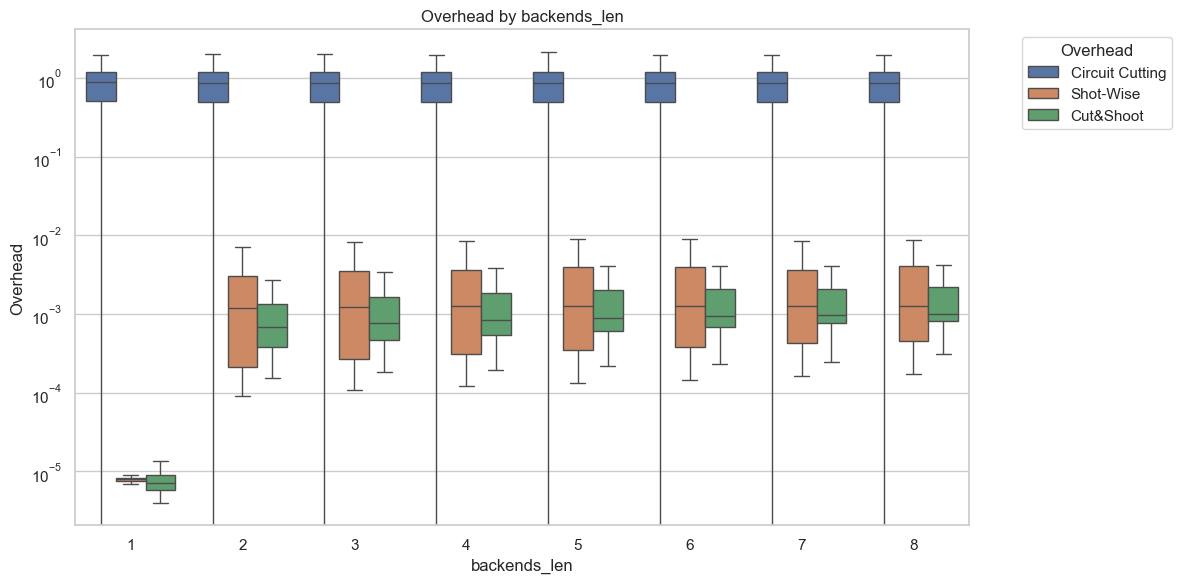

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a subset for cc_overhead
df_cc = df[['backends_len', 'cc_overhead']].copy()
df_cc = df_cc.rename(columns={'cc_overhead': 'overhead_value'})
df_cc['overhead_type'] = 'Circuit Cutting'

# Create a subset for sw_overhead when cc_overhead is zero
df_sw_zero = df[df['cc_overhead'] == 0][['backends_len', 'sw_overhead']].copy()
df_sw_zero = df_sw_zero.rename(columns={'sw_overhead': 'overhead_value'})
df_sw_zero['overhead_type'] = 'Shot-Wise (Without Circuit Cutting)'

# Create a subset for sw_overhead when cc_overhead is not zero
df_sw_nonzero = df[df['cc_overhead'] != 0][['backends_len', 'sw_overhead']].copy()
df_sw_nonzero = df_sw_nonzero.rename(columns={'sw_overhead': 'overhead_value'})
df_sw_nonzero['overhead_type'] = 'Shot-Wise (After Circuit Cutting)'

# Concatenate the three subsets into one dataframe
df_long = pd.concat([df_cc, df_sw_zero, df_sw_nonzero], ignore_index=True)

# Plot the boxplots with three groups per x value
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="backends_len", 
    y="overhead_value", 
    hue="overhead_type", 
    data=df_long,
    showfliers=False
)
plt.title("Overhead by backends_len")
plt.xlabel("backends_len")
plt.ylabel("Overhead")
plt.legend(title="Overhead", bbox_to_anchor=(1.05, 1), loc=2)
plt.yscale("log")
plt.tight_layout()
plt.savefig(f"{plots_dir}overhead_by_backends_len.png")
plt.show()